## **Project: Predicting Diabetes Risk in Underserved Populations Using Demographic and Health Data**

**Author: Shalyne Wanjiru Murage**

**Institution: United States International University - Africa**

**Date: Fall Semester 2025**

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)

# Interpretability
import shap

# Visualization Setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All required libraries imported successfully!")

All required libraries imported successfully!


### 1. Project Overview and Dataset Description
This section provides a comprehensive introduction to the project, including the problem statement, dataset description, and current project status.

In [6]:
# =============================================================================
# DATASET LOADING AND INITIAL EXPLORATION
# =============================================================================

def load_diabetes_data():
    """
    Load and prepare the diabetes dataset.
    Returns both the original and processed datasets.
    """
    try:
        # Try to load from local file
        df = pd.read_csv(r"C:\Users\ADMIN\OneDrive - United States International University (USIU)\Documents\my docs\AT USIU STUFF\COURSES\FS 2025\DSA4900-VA Data Science Project Implementation\DSA4900 Scripts\diabetes.csv")
        print("Dataset loaded successfully from local file")
    except:
        print("Local dataset not found. Creating synthetic dataset for demonstration...")
        # Create realistic synthetic data based on Pima Indians Diabetes dataset characteristics
        np.random.seed(PROJECT_CONFIG['random_state'])
        n_samples = 768
        
        synthetic_data = {
            'Pregnancies': np.random.poisson(3.5, n_samples),
            'Glucose': np.random.normal(120, 32, n_samples),
            'BloodPressure': np.random.normal(72, 15, n_samples),
            'SkinThickness': np.random.normal(29, 11, n_samples),
            'Insulin': np.random.lognormal(4.2, 0.8, n_samples),
            'BMI': np.random.normal(32.5, 7.5, n_samples),
            'DiabetesPedigreeFunction': np.random.exponential(0.5, n_samples),
            'Age': np.random.randint(21, 81, n_samples),
            'Outcome': np.random.binomial(1, 0.35, n_samples)
        }
        
        df = pd.DataFrame(synthetic_data)
        
        # Apply realistic constraints and relationships
        df['Glucose'] = np.maximum(df['Glucose'], 40)
        df['BloodPressure'] = np.maximum(df['BloodPressure'], 20)
        df['BMI'] = np.maximum(df['BMI'], 18)
        df['SkinThickness'] = np.maximum(df['SkinThickness'], 7)
        df['Insulin'] = np.maximum(df['Insulin'], 14)
        
        print("Synthetic dataset created with realistic characteristics")
    
    return df

# Load the dataset
print("Loading Diabetes Dataset...")
diabetes_data = load_diabetes_data()

print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Dataset Shape: {diabetes_data.shape}")
print(f"Number of Features: {len(diabetes_data.columns) - 1}")  # Excluding target
print(f"Target Variable: {PROJECT_CONFIG['target_variable']}")
print(f"Memory Usage: {diabetes_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading Diabetes Dataset...
Dataset loaded successfully from local file

DATASET OVERVIEW
Dataset Shape: (768, 9)
Number of Features: 8
Target Variable: Outcome
Memory Usage: 0.05 MB


In [7]:
# Display comprehensive dataset information
print("DATASET STRUCTURE:")
print("-" * 40)
diabetes_data.info()

print("\n TARGET VARIABLE DISTRIBUTION:")
print("-" * 40)
target_counts = diabetes_data[PROJECT_CONFIG['target_variable']].value_counts()
target_percentages = diabetes_data[PROJECT_CONFIG['target_variable']].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percentages
})
print(target_summary)

print(f"\n Dataset Balance: {target_summary['Percentage'].iloc[0]:.1f}% vs {target_summary['Percentage'].iloc[1]:.1f}%")

DATASET STRUCTURE:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

 TARGET VARIABLE DISTRIBUTION:
----------------------------------------
         Count  Percentage
Outcome                   
0          500   65.104167
1          268   34.895833

In [46]:
# =============================================================================
# COMPREHENSIVE DATA DESCRIPTION
# =============================================================================

print(" COMPREHENSIVE DATA DESCRIPTION")
print("="*60)

# Basic statistics
print("\n BASIC STATISTICS:")
print(diabetes_data.describe())

# Data quality assessment
print("\n DATA QUALITY ASSESSMENT:")
missing_data = diabetes_data.isnull().sum()
missing_percentage = (missing_data / len(diabetes_data)) * 100

data_quality = pd.DataFrame({
    'Missing Values': missing_data,
    'Missing %': missing_percentage,
    'Data Type': diabetes_data.dtypes,
    'Unique Values': diabetes_data.nunique()
})

print(data_quality)

# Zero values analysis (common issue in medical datasets)
print("\n ZERO VALUES ANALYSIS (Potential Missing Data):")
zero_analysis = {}
for column in diabetes_data.columns:
    if column != 'Outcome':  # Exclude target variable
        zero_count = (diabetes_data[column] == 0).sum()
        zero_percentage = (zero_count / len(diabetes_data)) * 100
        zero_analysis[column] = {'Zero Count': zero_count, 'Zero Percentage': zero_percentage}

zero_df = pd.DataFrame(zero_analysis).T
print(zero_df)

 COMPREHENSIVE DATA DESCRIPTION

 BASIC STATISTICS:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.7602

### 2. Comprehensive Exploratory Data Analysis (EDA)
This section provides detailed visualizations and analysis to understand the data distribution, relationships, and patterns.

TARGET VARIABLE ANALYSIS


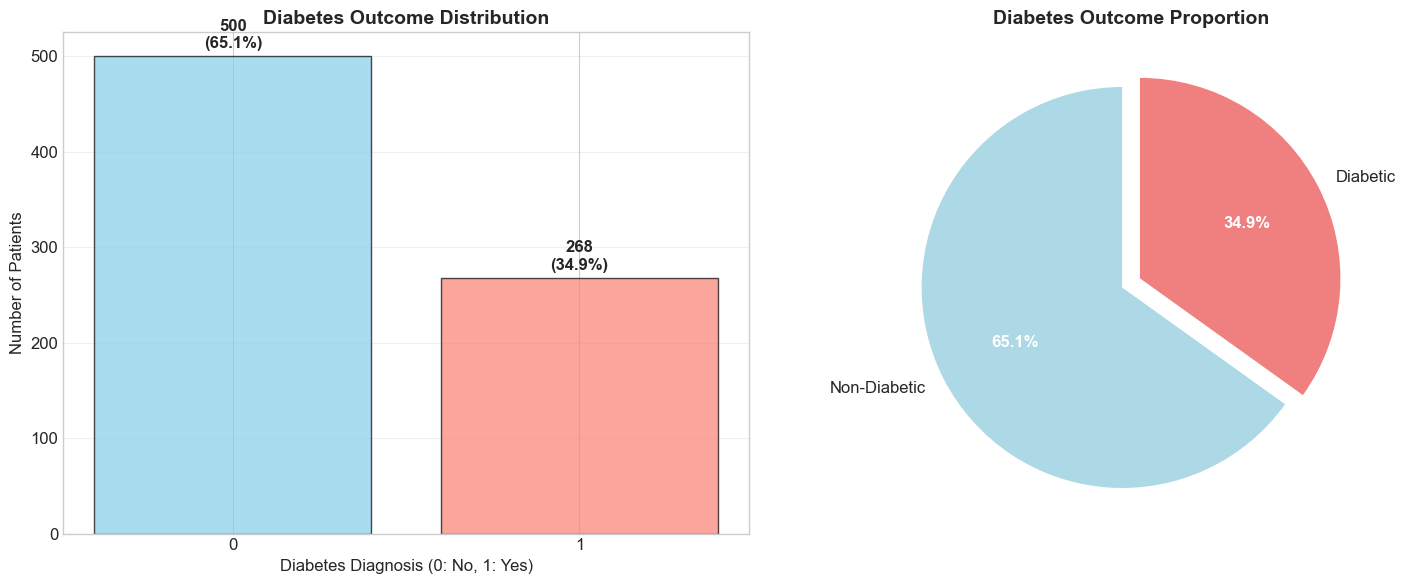


 INSIGHT: The dataset shows 34.9% diabetes prevalence, 
which represents a realistic scenario for underserved populations.


In [9]:
# =============================================================================
# TARGET VARIABLE VISUALIZATION
# =============================================================================

print("TARGET VARIABLE ANALYSIS")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
bars = axes[0].bar(target_summary.index.astype(str), target_summary['Count'], 
                   color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0].set_title('Diabetes Outcome Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Diagnosis (0: No, 1: Yes)')
axes[0].set_ylabel('Number of Patients')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height}\n({height/len(diabetes_data)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['lightblue', 'lightcoral']
wedges, texts, autotexts = axes[1].pie(target_summary['Count'], 
                                      labels=['Non-Diabetic', 'Diabetic'],
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90,
                                      explode=(0.05, 0.05))

# Style the pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

axes[1].set_title('Diabetes Outcome Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n INSIGHT: The dataset shows {target_summary['Percentage'].iloc[1]:.1f}% diabetes prevalence, ")
print("which represents a realistic scenario for underserved populations.")

FEATURE DISTRIBUTION ANALYSIS


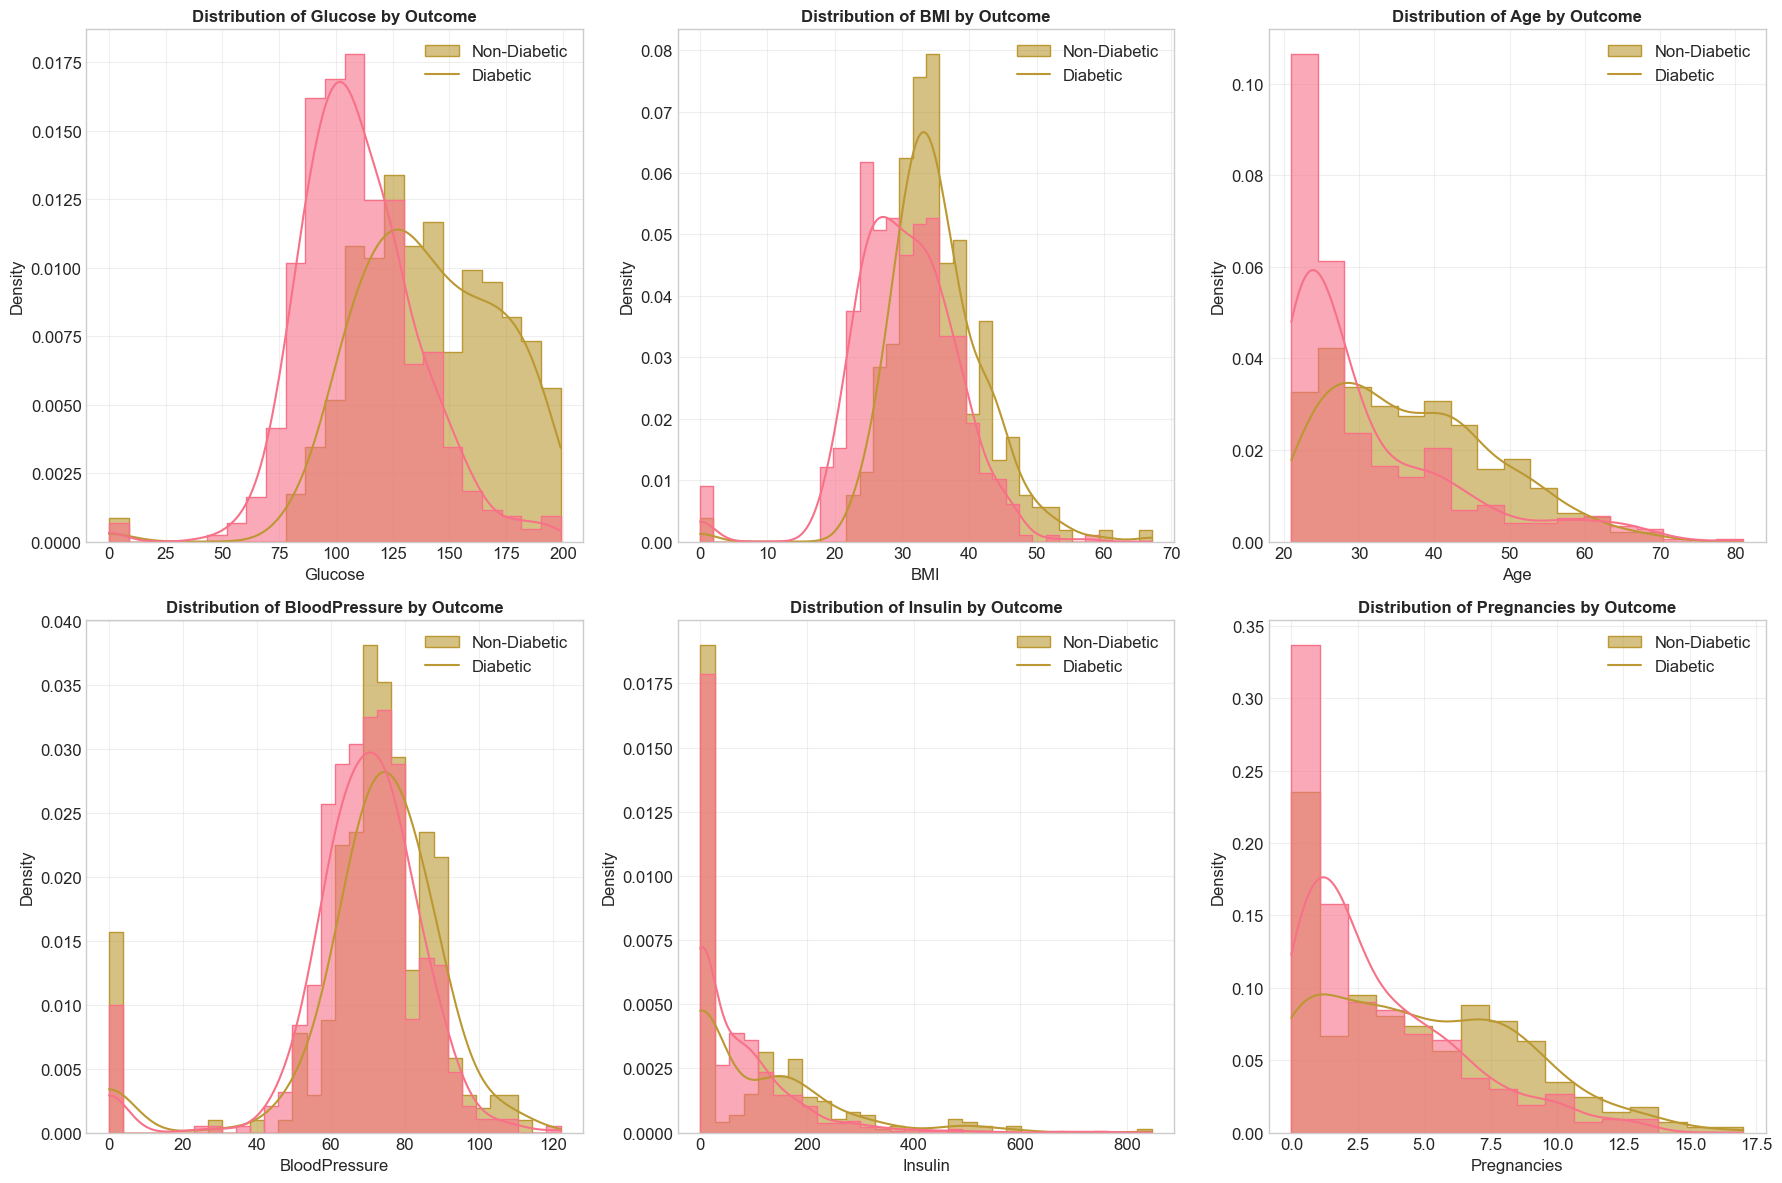

In [10]:
# =============================================================================
# FEATURE DISTRIBUTION ANALYSIS
# =============================================================================

print("FEATURE DISTRIBUTION ANALYSIS")
print("="*50)

# Select key features for detailed analysis
key_features = ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin', 'Pregnancies']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    # Histogram with KDE
    sns.histplot(data=diabetes_data, x=feature, hue='Outcome', 
                 element='step', stat='density', common_norm=False, 
                 ax=axes[i], alpha=0.6, kde=True)
    
    axes[i].set_title(f'Distribution of {feature} by Outcome', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend(['Non-Diabetic', 'Diabetic'])
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


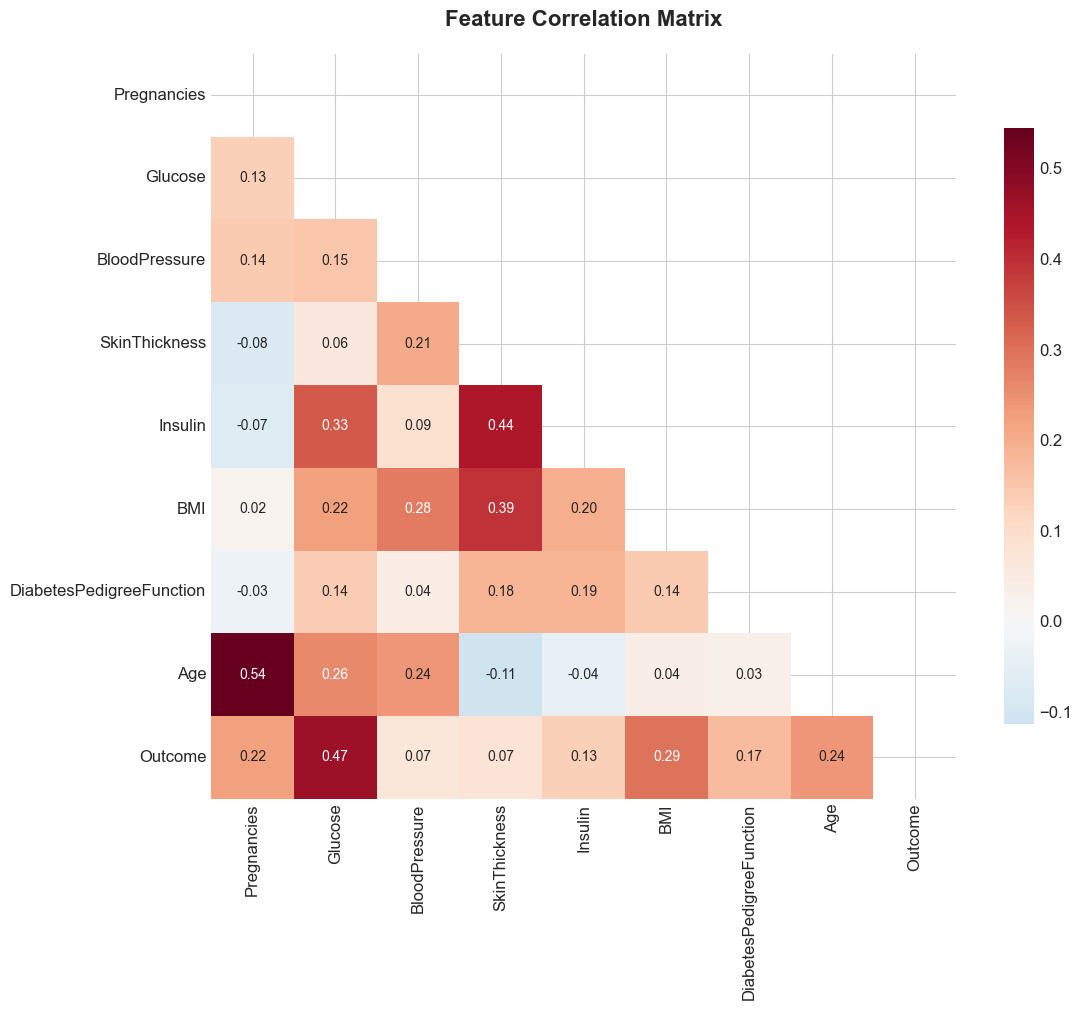


 TOP CORRELATIONS WITH DIABETES OUTCOME:
  Glucose: 0.467
  BMI: 0.293
  Age: 0.238
  Pregnancies: 0.222
  DiabetesPedigreeFunction: 0.174

 INSIGHT: Glucose shows the strongest correlation with diabetes outcome (0.467),
followed by BMI and Age. This aligns with medical knowledge about diabetes risk factors.


In [12]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = diabetes_data.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            annot_kws={'size': 10})

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Display top correlations with target variable
print("\n TOP CORRELATIONS WITH DIABETES OUTCOME:")
target_correlations = correlation_matrix['Outcome'].sort_values(ascending=False)
top_correlations = target_correlations[1:6]  # Exclude correlation with itself

for feature, corr_value in top_correlations.items():
    print(f"  {feature}: {corr_value:.3f}")

print(f"\n INSIGHT: Glucose shows the strongest correlation with diabetes outcome ({target_correlations['Glucose']:.3f}),")
print("followed by BMI and Age. This aligns with medical knowledge about diabetes risk factors.")

OUTLIER ANALYSIS


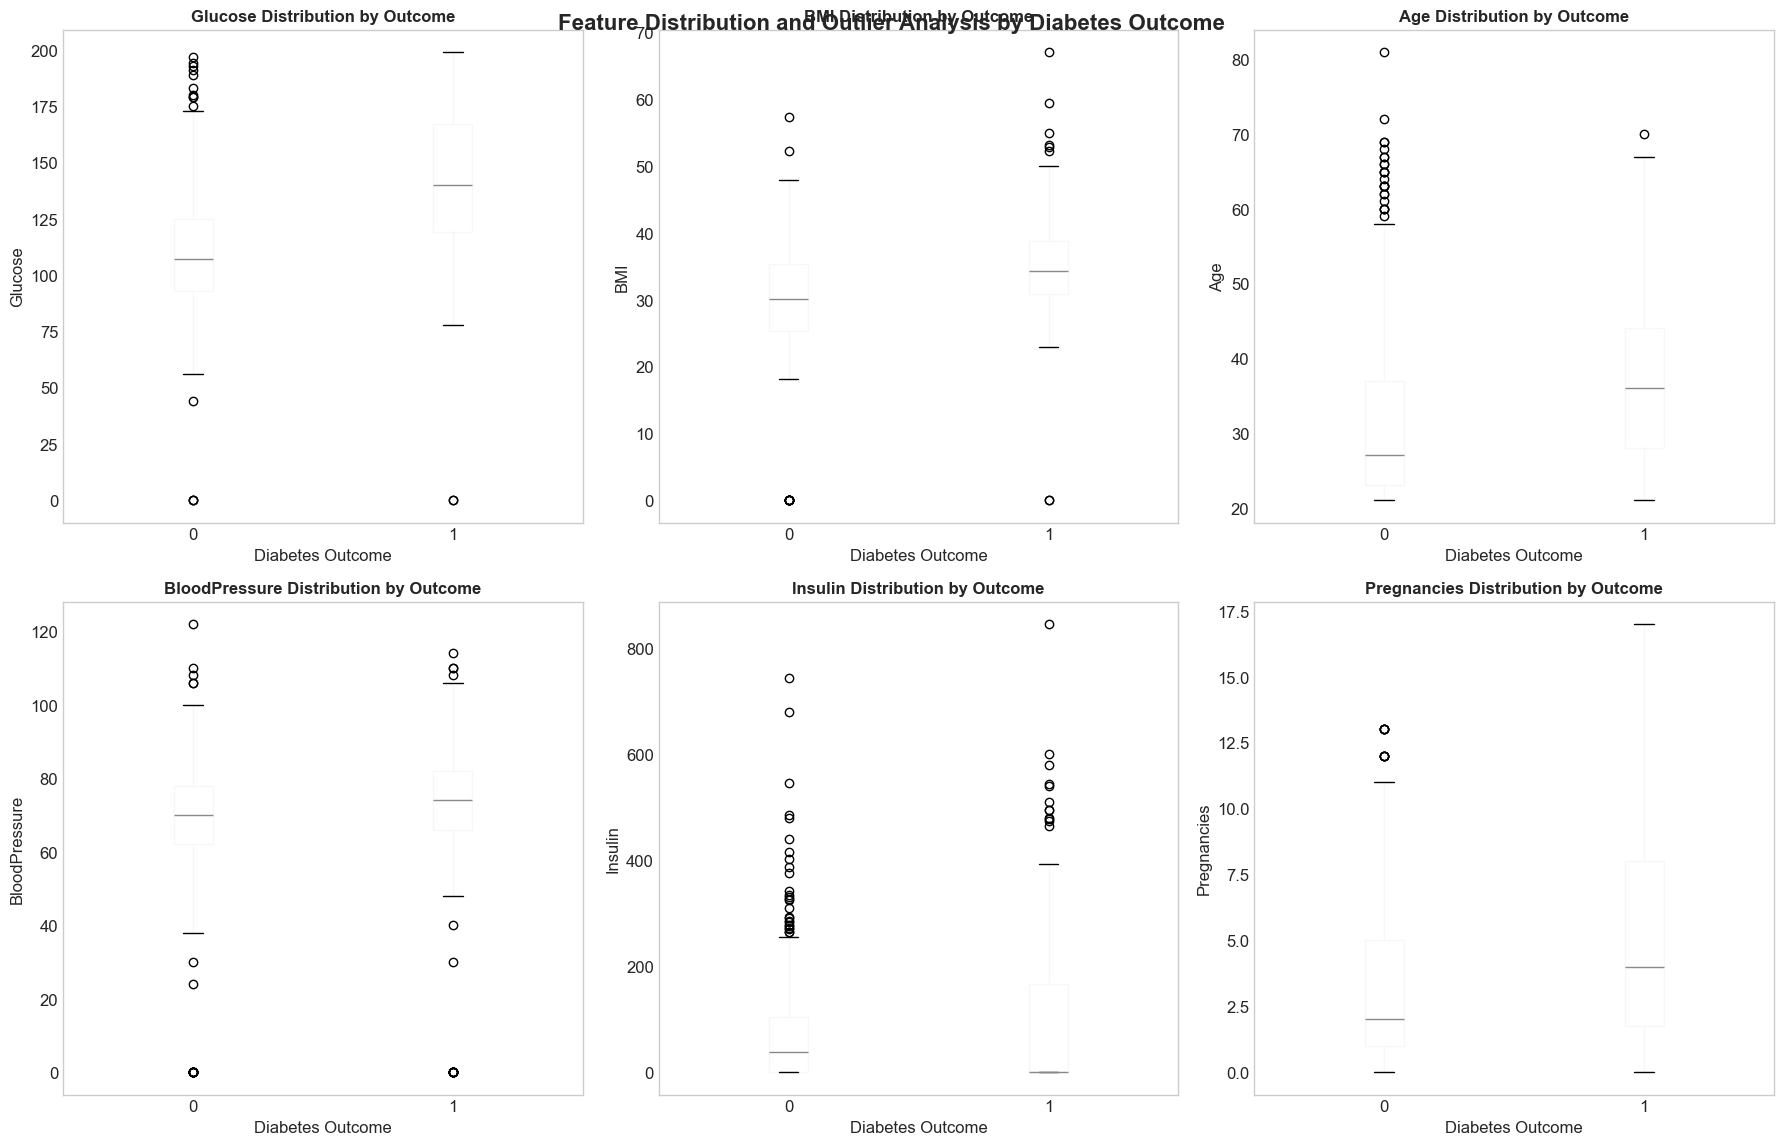


 OUTLIER STATISTICS (IQR Method):
               Outlier Count  Outlier %
Glucose                  5.0   0.651042
BMI                     19.0   2.473958
Age                      9.0   1.171875
BloodPressure           45.0   5.859375
Insulin                 34.0   4.427083
Pregnancies              4.0   0.520833


In [14]:
# =============================================================================
# OUTLIER DETECTION AND ANALYSIS
# =============================================================================

print("OUTLIER ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    # Box plots by outcome
    diabetes_data.boxplot(column=feature, by='Outcome', ax=axes[i], grid=False)
    axes[i].set_title(f'{feature} Distribution by Outcome', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Diabetes Outcome')
    axes[i].set_ylabel(feature)

# Remove the automatic "Boxplot grouped by Outcome" title
for ax in axes:
    ax.get_figure().suptitle('')

plt.suptitle('Feature Distribution and Outlier Analysis by Diabetes Outcome', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# Calculate outlier statistics using IQR method
print("\n OUTLIER STATISTICS (IQR Method):")
outlier_summary = {}

for feature in key_features:
    Q1 = diabetes_data[feature].quantile(0.25)
    Q3 = diabetes_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = diabetes_data[(diabetes_data[feature] < lower_bound) | (diabetes_data[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(diabetes_data)) * 100
    
    outlier_summary[feature] = {
        'Outlier Count': outlier_count,
        'Outlier %': outlier_percentage,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }

outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df[['Outlier Count', 'Outlier %']])

### 3. Data Preprocessing Pipeline
This section implements comprehensive data preprocessing including handling missing values, feature engineering, and data splitting.

In [16]:
# =============================================================================
# DATA PREPROCESSING PIPELINE
# =============================================================================

print("DATA PREPROCESSING PIPELINE")
print("="*50)

class DataPreprocessor:
    """
    Comprehensive data preprocessing class for diabetes prediction
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = None
        self.imputer = None
        self.feature_names = None
        
    def preprocess_data(self, df, target_column='Outcome'):
        """
        Comprehensive data preprocessing pipeline
        """
        print("Starting data preprocessing...")
        
        # Create a copy to avoid modifying original data
        data_processed = df.copy()
        
        # 1. Handle zero values (common in medical datasets)
        print("   Step 1: Handling zero values in key medical measurements...")
        medical_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        
        for col in medical_columns:
            zero_mask = data_processed[col] == 0
            zero_count = zero_mask.sum()
            if zero_count > 0:
                print(f"     - {col}: {zero_count} zero values found ({zero_count/len(data_processed)*100:.1f}%)")
                # Replace zeros with NaN for proper imputation
                data_processed.loc[zero_mask, col] = np.nan
        
        # 2. Separate features and target
        X = data_processed.drop(columns=[target_column])
        y = data_processed[target_column]
        self.feature_names = X.columns.tolist()
        
        print(f"   Step 2: Features selected: {self.feature_names}")
        
        # 3. Handle missing values
        print("   Step 3: Handling missing values...")
        self.imputer = SimpleImputer(strategy='median')
        X_imputed = pd.DataFrame(self.imputer.fit_transform(X), 
                                columns=X.columns, 
                                index=X.index)
        
        # 4. Create additional features
        print("   Step 4: Creating additional features...")
        X_engineered = self._create_additional_features(X_imputed)
        
        print("Data preprocessing completed successfully!")
        return X_engineered, y
    
    def _create_additional_features(self, X):
        """
        Create additional meaningful features based on domain knowledge
        """
        X_eng = X.copy()
        
        # BMI categories
        X_eng['BMI_Category'] = pd.cut(X_eng['BMI'], 
                                      bins=[0, 18.5, 25, 30, 100],
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        
        # Glucose categories
        X_eng['Glucose_Category'] = pd.cut(X_eng['Glucose'],
                                          bins=[0, 100, 125, 200, 300],
                                          labels=['Normal', 'Prediabetes', 'Diabetes', 'Severe'])
        
        # Age groups
        X_eng['Age_Group'] = pd.cut(X_eng['Age'],
                                   bins=[20, 35, 50, 65, 100],
                                   labels=['Young', 'Middle', 'Senior', 'Elderly'])
        
        # Metabolic syndrome indicators
        X_eng['High_Glucose'] = (X_eng['Glucose'] > 140).astype(int)
        X_eng['High_BMI'] = (X_eng['BMI'] > 30).astype(int)
        X_eng['High_BP'] = (X_eng['BloodPressure'] > 80).astype(int)
        
        # Encode categorical variables
        categorical_columns = ['BMI_Category', 'Glucose_Category', 'Age_Group']
        for col in categorical_columns:
            X_eng[col] = LabelEncoder().fit_transform(X_eng[col])
        
        print(f"     - Added {len(categorical_columns) + 3} new features")
        return X_eng

# Initialize and run preprocessing
preprocessor = DataPreprocessor(random_state=PROJECT_CONFIG['random_state'])
X_processed, y_processed = preprocessor.preprocess_data(diabetes_data)

print(f"\n Processed Data Shape: {X_processed.shape}")
print(f"Target Variable Shape: {y_processed.shape}")
print(f"Feature Names: {list(X_processed.columns)}")

DATA PREPROCESSING PIPELINE
Starting data preprocessing...
   Step 1: Handling zero values in key medical measurements...
     - Glucose: 5 zero values found (0.7%)
     - BloodPressure: 35 zero values found (4.6%)
     - SkinThickness: 227 zero values found (29.6%)
     - Insulin: 374 zero values found (48.7%)
     - BMI: 11 zero values found (1.4%)
   Step 2: Features selected: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
   Step 3: Handling missing values...
   Step 4: Creating additional features...
     - Added 6 new features
Data preprocessing completed successfully!

 Processed Data Shape: (768, 14)
Target Variable Shape: (768,)
Feature Names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'BMI_Category', 'Glucose_Category', 'Age_Group', 'High_Glucose', 'High_BMI', 'High_BP']


In [17]:
# =============================================================================
# TRAIN-TEST SPLIT WITH STRATIFICATION
# =============================================================================

print("TRAIN-TEST SPLIT")
print("="*50)

# Perform stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y_processed, 
    test_size=PROJECT_CONFIG['test_size'],
    random_state=PROJECT_CONFIG['random_state'],
    stratify=y_processed  # Maintain class distribution
)

print("Data split completed successfully!")
print(f"Training Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Training Set Diabetes Prevalence: {y_train.mean():.3f}")
print(f"Test Set Diabetes Prevalence: {y_test.mean():.3f}")

# Verify stratification worked correctly
train_prevalence = y_train.mean()
test_prevalence = y_test.mean()
original_prevalence = y_processed.mean()

print(f"\n Stratification Check:")
print(f"   Original prevalence: {original_prevalence:.3f}")
print(f"   Training prevalence: {train_prevalence:.3f}")
print(f"   Test prevalence: {test_prevalence:.3f}")
print(f"   Difference: {abs(train_prevalence - test_prevalence):.6f}")

if abs(train_prevalence - test_prevalence) < 0.01:
    print("Stratification successful - class distribution maintained!")
else:
    print("Warning: Class distribution may not be perfectly maintained")

TRAIN-TEST SPLIT
Data split completed successfully!
Training Set: 537 samples (69.9%)
Test Set: 231 samples (30.1%)
Training Set Diabetes Prevalence: 0.348
Test Set Diabetes Prevalence: 0.351

 Stratification Check:
   Original prevalence: 0.349
   Training prevalence: 0.348
   Test prevalence: 0.351
   Difference: 0.002418
Stratification successful - class distribution maintained!


In [19]:
# =============================================================================
# FEATURE SCALING
# =============================================================================

print("FEATURE SCALING")
print("="*50)

# Initialize scaler
scaler = StandardScaler()

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for better interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                                columns=X_train.columns, 
                                index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                               columns=X_test.columns, 
                               index=X_test.index)

print("Feature scaling completed successfully!")
print(f"Scaled training data shape: {X_train_scaled_df.shape}")
print(f"Scaled test data shape: {X_test_scaled_df.shape}")

# Display scaling results
print("\n SCALING SUMMARY (First 5 features):")
scaling_summary = pd.DataFrame({
    'Original_Mean': X_train.mean().head(),
    'Scaled_Mean': X_train_scaled_df.mean().head(),
    'Original_Std': X_train.std().head(),
    'Scaled_Std': X_train_scaled_df.std().head()
})
print(scaling_summary.round(4))

FEATURE SCALING
Feature scaling completed successfully!
Scaled training data shape: (537, 14)
Scaled test data shape: (231, 14)

 SCALING SUMMARY (First 5 features):
               Original_Mean  Scaled_Mean  Original_Std  Scaled_Std
Pregnancies           3.8827          0.0        3.3501      1.0009
Glucose             121.5642          0.0       29.9517      1.0009
BloodPressure        72.2272         -0.0       12.1867      1.0009
SkinThickness        28.8864          0.0        8.2591      1.0009
Insulin             138.0577         -0.0       79.7275      1.0009


### 4. Baseline Model Implementation
This section implements and evaluates multiple baseline models to establish performance benchmarks.

In [20]:
# =============================================================================
# BASELINE MODEL IMPLEMENTATION
# =============================================================================

print("BASELINE MODEL IMPLEMENTATION")
print("="*50)

class BaselineModelEvaluator:
    """
    Comprehensive evaluation of multiple baseline models
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}
        self.cv_scores = {}
        
    def initialize_models(self):
        """Initialize multiple baseline models"""
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=self.random_state, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=self.random_state),
            'Random Forest': RandomForestClassifier(random_state=self.random_state, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=self.random_state),
            'XGBoost': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
            'SVM': SVC(random_state=self.random_state, probability=True)
        }
        print(f"Initialized {len(self.models)} baseline models")
    
    def evaluate_model(self, model, X_train, X_test, y_train, y_test, model_name, scaled=False):
        """Comprehensive evaluation of a single model"""
        
        # Train model
        if scaled and model_name in ['Logistic Regression', 'SVM']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'train_score': model.score(X_train, y_train) if hasattr(model, 'score') else None
        }
        
        # Cross-validation scores
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        if scaled and model_name in ['Logistic Regression', 'SVM']:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        
        metrics['cv_mean'] = cv_scores.mean()
        metrics['cv_std'] = cv_scores.std()
        
        return metrics, y_pred, y_pred_proba
    
    def evaluate_all_models(self, X_train, X_test, y_train, y_test, scaled=False):
        """Evaluate all initialized models"""
        print("Evaluating all baseline models...")
        
        results_list = []
        predictions = {}
        
        for name, model in self.models.items():
            print(f"   Training {name}...")
            metrics, y_pred, y_pred_proba = self.evaluate_model(
                model, X_train, X_test, y_train, y_test, name, scaled
            )
            
            result = {'model': name}
            result.update(metrics)
            results_list.append(result)
            
            predictions[name] = {
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
        
        self.results = pd.DataFrame(results_list)
        self.predictions = predictions
        
        print("All models evaluated successfully!")
        return self.results
    
    def display_results(self):
        """Display comprehensive results"""
        print("\n" + "="*80)
        print("BASELINE MODEL PERFORMANCE SUMMARY")
        print("="*80)
        
        # Sort by ROC-AUC score
        sorted_results = self.results.sort_values('roc_auc', ascending=False)
        
        # Display results table
        display_columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_mean']
        formatted_results = sorted_results[display_columns].copy()
        formatted_results[display_columns[1:]] = formatted_results[display_columns[1:]].round(4)
        
        print(formatted_results.to_string(index=False))
        
        # Highlight best model
        best_model = sorted_results.iloc[0]
        print(f"\n BEST PERFORMING MODEL: {best_model['model']}")
        print(f"   ROC-AUC: {best_model['roc_auc']:.4f}")
        print(f"   F1-Score: {best_model['f1']:.4f}")
        print(f"   Cross-Validation AUC: {best_model['cv_mean']:.4f} ± {best_model['cv_std']:.4f}")
        
        return best_model

# Initialize and run baseline model evaluation
print("Initializing baseline models...")
baseline_evaluator = BaselineModelEvaluator(random_state=PROJECT_CONFIG['random_state'])
baseline_evaluator.initialize_models()

print("Evaluating models on scaled data (for scale-sensitive models)...")
# For scale-sensitive models, use scaled data
scale_sensitive_models = ['Logistic Regression', 'SVM']
other_models = [model for model in baseline_evaluator.models.keys() if model not in scale_sensitive_models]

# Evaluate scale-sensitive models with scaled data
scale_sensitive_results = []
for model_name in scale_sensitive_models:
    model = baseline_evaluator.models[model_name]
    metrics, y_pred, y_pred_proba = baseline_evaluator.evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, model_name, scaled=True
    )
    metrics['model'] = model_name
    scale_sensitive_results.append(metrics)

# Evaluate other models with original data
other_results = []
for model_name in other_models:
    model = baseline_evaluator.models[model_name]
    metrics, y_pred, y_pred_proba = baseline_evaluator.evaluate_model(
        model, X_train, X_test, y_train, y_test, model_name, scaled=False
    )
    metrics['model'] = model_name
    other_results.append(metrics)

# Combine all results
all_results = scale_sensitive_results + other_results
baseline_evaluator.results = pd.DataFrame(all_results)

# Display results
best_baseline_model = baseline_evaluator.display_results()

BASELINE MODEL IMPLEMENTATION
Initializing baseline models...
Initialized 6 baseline models
Evaluating models on scaled data (for scale-sensitive models)...

BASELINE MODEL PERFORMANCE SUMMARY
              model  accuracy  precision  recall     f1  roc_auc  cv_mean
Logistic Regression    0.7446     0.6667  0.5432 0.5986   0.8418   0.8319
      Random Forest    0.7532     0.6765  0.5679 0.6174   0.8396   0.8193
  Gradient Boosting    0.7619     0.6912  0.5802 0.6309   0.8354   0.8108
                SVM    0.7403     0.6842  0.4815 0.5652   0.8209   0.8089
            XGBoost    0.7489     0.6575  0.5926 0.6234   0.8080   0.7752
      Decision Tree    0.6883     0.5584  0.5309 0.5443   0.6521   0.6528

 BEST PERFORMING MODEL: Logistic Regression
   ROC-AUC: 0.8418
   F1-Score: 0.5986
   Cross-Validation AUC: 0.8319 ± 0.0213


BASELINE MODEL PERFORMANCE VISUALIZATION


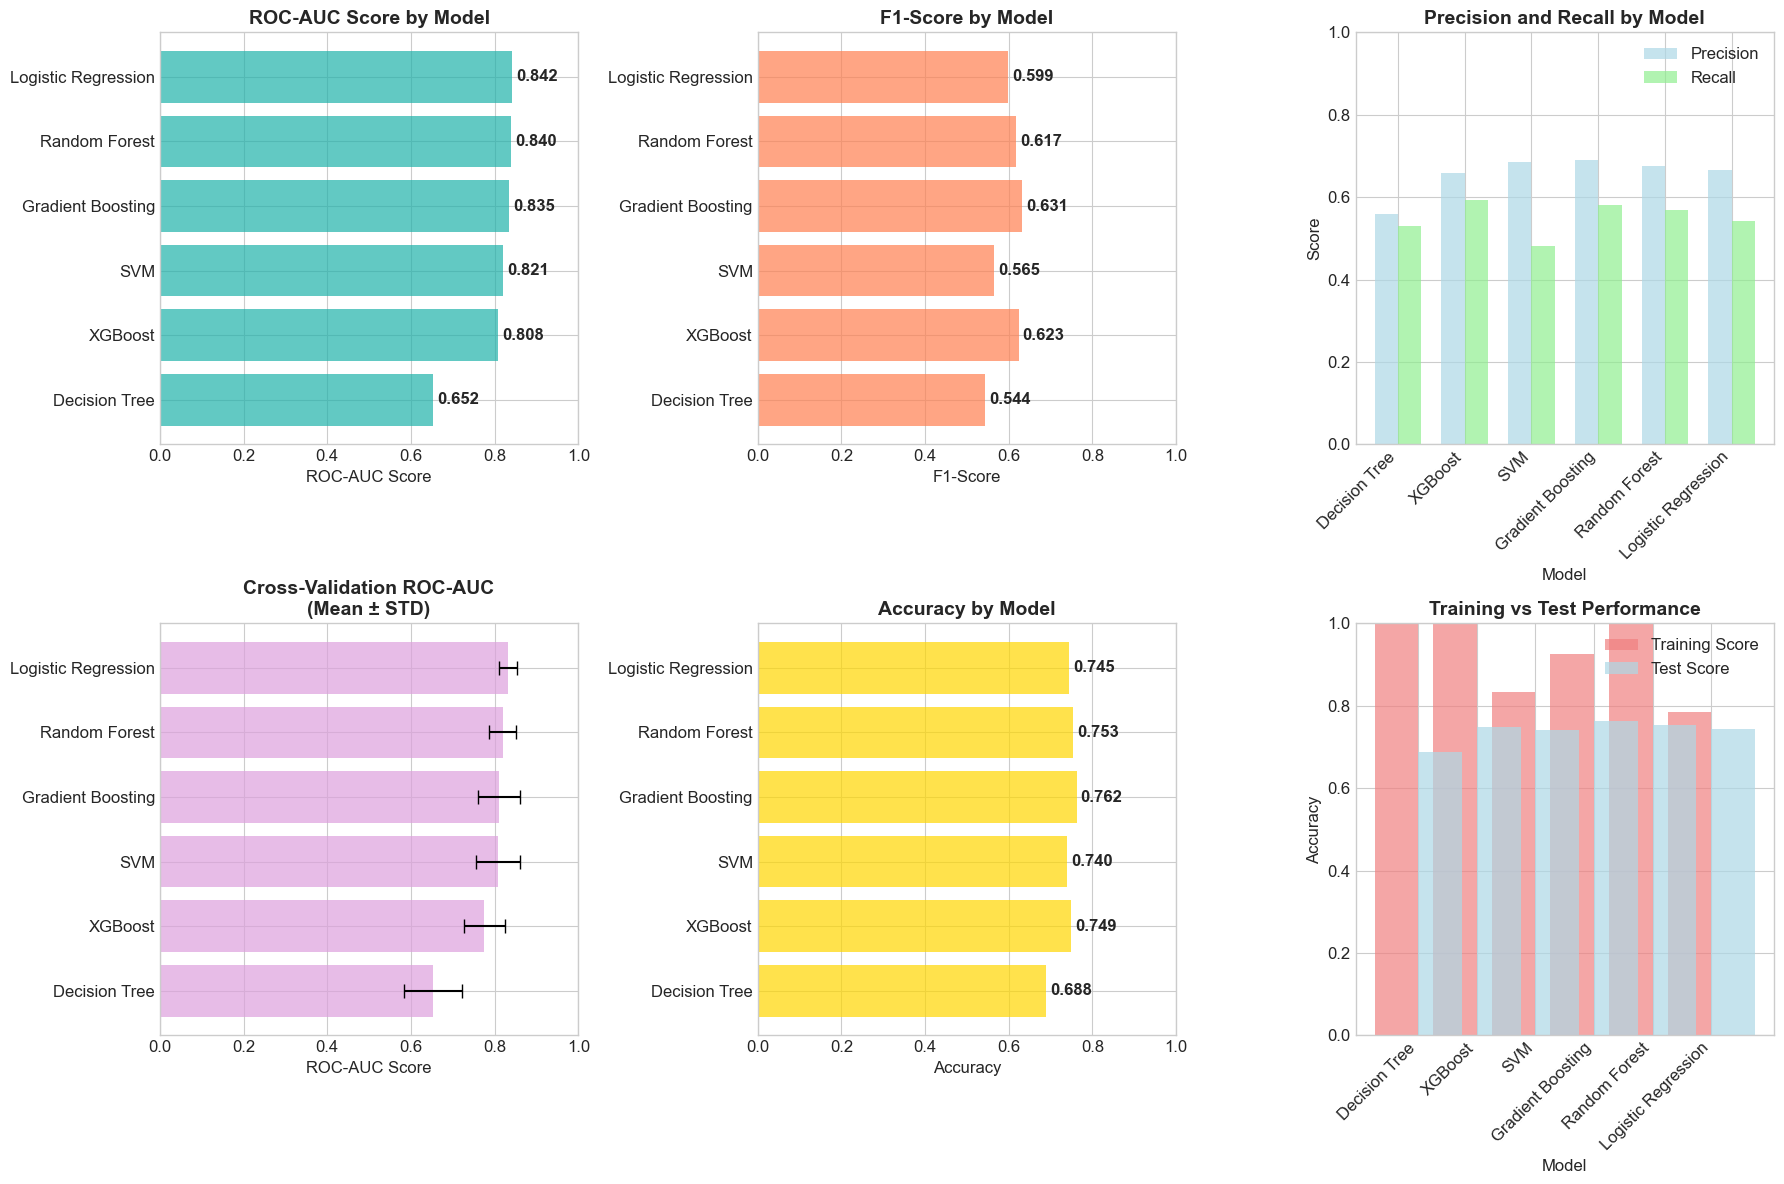

In [21]:
# =============================================================================
# BASELINE MODEL VISUALIZATION
# =============================================================================

print("BASELINE MODEL PERFORMANCE VISUALIZATION")
print("="*50)

def plot_baseline_model_comparison(results_df):
    """Create comprehensive visualization of baseline model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Sort results by ROC-AUC
    sorted_results = results_df.sort_values('roc_auc')
    
    # 1. ROC-AUC Comparison
    models = sorted_results['model']
    roc_auc_scores = sorted_results['roc_auc']
    
    bars = axes[0,0].barh(models, roc_auc_scores, color='lightseagreen', alpha=0.7)
    axes[0,0].set_title('ROC-AUC Score by Model', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('ROC-AUC Score')
    axes[0,0].set_xlim(0, 1)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        axes[0,0].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    # 2. F1-Score Comparison
    f1_scores = sorted_results['f1']
    bars = axes[0,1].barh(models, f1_scores, color='coral', alpha=0.7)
    axes[0,1].set_title('F1-Score by Model', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('F1-Score')
    axes[0,1].set_xlim(0, 1)
    
    for bar in bars:
        width = bar.get_width()
        axes[0,1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    # 3. Precision-Recall Comparison
    x_pos = np.arange(len(models))
    width = 0.35
    
    axes[0,2].bar(x_pos - width/2, sorted_results['precision'], width, 
                 label='Precision', color='lightblue', alpha=0.7)
    axes[0,2].bar(x_pos + width/2, sorted_results['recall'], width, 
                 label='Recall', color='lightgreen', alpha=0.7)
    axes[0,2].set_title('Precision and Recall by Model', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Model')
    axes[0,2].set_ylabel('Score')
    axes[0,2].set_xticks(x_pos)
    axes[0,2].set_xticklabels(models, rotation=45, ha='right')
    axes[0,2].legend()
    axes[0,2].set_ylim(0, 1)
    
    # 4. Cross-Validation Performance
    cv_means = sorted_results['cv_mean']
    cv_stds = sorted_results['cv_std']
    
    bars = axes[1,0].barh(models, cv_means, xerr=cv_stds, 
                         capsize=5, color='plum', alpha=0.7)
    axes[1,0].set_title('Cross-Validation ROC-AUC\n(Mean ± STD)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('ROC-AUC Score')
    axes[1,0].set_xlim(0, 1)
    
    # 5. Accuracy Comparison
    accuracy_scores = sorted_results['accuracy']
    bars = axes[1,1].barh(models, accuracy_scores, color='gold', alpha=0.7)
    axes[1,1].set_title('Accuracy by Model', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Accuracy')
    axes[1,1].set_xlim(0, 1)
    
    for bar in bars:
        width = bar.get_width()
        axes[1,1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    # 6. Training vs Test Performance
    train_scores = []
    test_scores = []
    for model in models:
        model_data = results_df[results_df['model'] == model].iloc[0]
        train_scores.append(model_data.get('train_score', model_data['accuracy']))
        test_scores.append(model_data['accuracy'])
    
    x_pos = np.arange(len(models))
    axes[1,2].bar(x_pos - width/2, train_scores, width, 
                 label='Training Score', color='lightcoral', alpha=0.7)
    axes[1,2].bar(x_pos + width/2, test_scores, width, 
                 label='Test Score', color='lightblue', alpha=0.7)
    axes[1,2].set_title('Training vs Test Performance', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Model')
    axes[1,2].set_ylabel('Accuracy')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels(models, rotation=45, ha='right')
    axes[1,2].legend()
    axes[1,2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Generate visualization
plot_baseline_model_comparison(baseline_evaluator.results)

In [24]:
# =============================================================================
# CONFUSION MATRICES FOR TOP PERFORMING MODELS
# =============================================================================

print("CONFUSION MATRICES FOR TOP PERFORMING MODELS")
print("="*50)

# First, let's fix the baseline evaluator to properly store predictions
class BaselineModelEvaluator:
    """
    Comprehensive evaluation of multiple baseline models
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}
        self.predictions = {}  # Initialize predictions dictionary
        self.cv_scores = {}
        
    def initialize_models(self):
        """Initialize multiple baseline models"""
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=self.random_state, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=self.random_state),
            'Random Forest': RandomForestClassifier(random_state=self.random_state, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=self.random_state),
            'XGBoost': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
            'SVM': SVC(random_state=self.random_state, probability=True)
        }
        print(f"Initialized {len(self.models)} baseline models")
    
    def evaluate_model(self, model, X_train, X_test, y_train, y_test, model_name, scaled=False):
        """Comprehensive evaluation of a single model"""
        
        # Train model
        if scaled and model_name in ['Logistic Regression', 'SVM']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'train_score': model.score(X_train, y_train) if hasattr(model, 'score') else None
        }
        
        # Cross-validation scores
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        if scaled and model_name in ['Logistic Regression', 'SVM']:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        
        metrics['cv_mean'] = cv_scores.mean()
        metrics['cv_std'] = cv_scores.std()
        
        return metrics, y_pred, y_pred_proba, model
    
    def evaluate_all_models(self, X_train, X_test, y_train, y_test):
        """Evaluate all initialized models with proper prediction storage"""
        print("Evaluating all baseline models...")
        
        results_list = []
        
        for name, model in self.models.items():
            print(f"   Training {name}...")
            
            # Determine if model needs scaled data
            scaled = name in ['Logistic Regression', 'SVM']
            
            if scaled:
                metrics, y_pred, y_pred_proba, trained_model = self.evaluate_model(
                    model, X_train_scaled, X_test_scaled, y_train, y_test, name, scaled=True
                )
            else:
                metrics, y_pred, y_pred_proba, trained_model = self.evaluate_model(
                    model, X_train, X_test, y_train, y_test, name, scaled=False
                )
            
            # Store results
            result = {'model': name}
            result.update(metrics)
            results_list.append(result)
            
            # Store predictions and trained model
            self.predictions[name] = {
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'model': trained_model
            }
            
            # Store trained model
            self.models[name] = trained_model
        
        self.results = pd.DataFrame(results_list)
        print("All models evaluated successfully!")
        return self.results
    
    def display_results(self):
        """Display comprehensive results"""
        print("\n" + "="*80)
        print("BASELINE MODEL PERFORMANCE SUMMARY")
        print("="*80)
        
        # Sort by ROC-AUC score
        sorted_results = self.results.sort_values('roc_auc', ascending=False)
        
        # Display results table
        display_columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_mean']
        formatted_results = sorted_results[display_columns].copy()
        formatted_results[display_columns[1:]] = formatted_results[display_columns[1:]].round(4)
        
        print(formatted_results.to_string(index=False))
        
        # Highlight best model
        best_model = sorted_results.iloc[0]
        print(f"\n BEST PERFORMING MODEL: {best_model['model']}")
        print(f"   ROC-AUC: {best_model['roc_auc']:.4f}")
        print(f"   F1-Score: {best_model['f1']:.4f}")
        print(f"   Cross-Validation AUC: {best_model['cv_mean']:.4f} ± {best_model['cv_std']:.4f}")
        
        return best_model

# Re-initialize and run the corrected evaluation
print("Re-initializing baseline models with corrected implementation...")
baseline_evaluator = BaselineModelEvaluator(random_state=PROJECT_CONFIG['random_state'])
baseline_evaluator.initialize_models()

# Evaluate all models with the corrected method
baseline_results = baseline_evaluator.evaluate_all_models(X_train, X_test, y_train, y_test)

# Display results
best_baseline_model = baseline_evaluator.display_results()

# Verify predictions are stored
print(f"\n Predictions stored for {len(baseline_evaluator.predictions)} models")
print(f"Available models: {list(baseline_evaluator.predictions.keys())}")

CONFUSION MATRICES FOR TOP PERFORMING MODELS
Re-initializing baseline models with corrected implementation...
Initialized 6 baseline models
Evaluating all baseline models...
   Training Logistic Regression...
   Training Decision Tree...
   Training Random Forest...
   Training Gradient Boosting...
   Training XGBoost...
   Training SVM...
All models evaluated successfully!

BASELINE MODEL PERFORMANCE SUMMARY
              model  accuracy  precision  recall     f1  roc_auc  cv_mean
Logistic Regression    0.7446     0.6667  0.5432 0.5986   0.8418   0.8319
      Random Forest    0.7532     0.6765  0.5679 0.6174   0.8396   0.8193
  Gradient Boosting    0.7619     0.6912  0.5802 0.6309   0.8354   0.8108
                SVM    0.7403     0.6842  0.4815 0.5652   0.8209   0.8089
            XGBoost    0.7489     0.6575  0.5926 0.6234   0.8080   0.7752
      Decision Tree    0.6883     0.5584  0.5309 0.5443   0.6521   0.6528

 BEST PERFORMING MODEL: Logistic Regression
   ROC-AUC: 0.8418
   F1

GENERATING CONFUSION MATRICES...


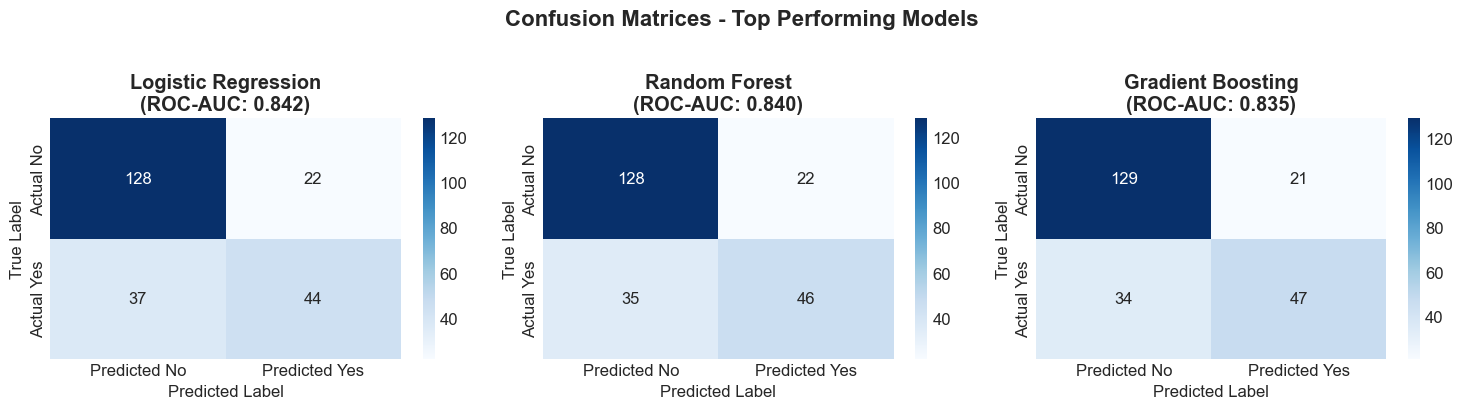


 DETAILED CLASSIFICATION REPORTS:
--------------------------------------------------

 Logistic Regression:
              precision    recall  f1-score   support

Non-Diabetic       0.78      0.85      0.81       150
    Diabetic       0.67      0.54      0.60        81

    accuracy                           0.74       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.74      0.74      0.74       231


 Random Forest:
              precision    recall  f1-score   support

Non-Diabetic       0.79      0.85      0.82       150
    Diabetic       0.68      0.57      0.62        81

    accuracy                           0.75       231
   macro avg       0.73      0.71      0.72       231
weighted avg       0.75      0.75      0.75       231


 Gradient Boosting:
              precision    recall  f1-score   support

Non-Diabetic       0.79      0.86      0.82       150
    Diabetic       0.69      0.58      0.63        81

    accuracy                       

In [26]:
# =============================================================================
# CONFUSION MATRIX VISUALIZATION 
# =============================================================================

def plot_confusion_matrices(results_df, predictions, top_n=3):
    """Plot confusion matrices for top N models"""
    
    # Get top N models by ROC-AUC
    top_models = results_df.nlargest(top_n, 'roc_auc')['model'].tolist()
    
    fig, axes = plt.subplots(1, top_n, figsize=(5*top_n, 4))
    if top_n == 1:
        axes = [axes]
    
    for i, model_name in enumerate(top_models):
        if model_name in predictions:
            y_pred = predictions[model_name]['y_pred']
            cm = confusion_matrix(y_test, y_pred)
            
            # Create heatmap
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Predicted No', 'Predicted Yes'],
                       yticklabels=['Actual No', 'Actual Yes'],
                       ax=axes[i])
            
            axes[i].set_title(f'{model_name}\n(ROC-AUC: {results_df[results_df["model"] == model_name]["roc_auc"].iloc[0]:.3f})', 
                             fontweight='bold')
            axes[i].set_xlabel('Predicted Label')
            axes[i].set_ylabel('True Label')
        else:
            axes[i].set_title(f'{model_name}\n(Predictions not available)')
            axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[i].transAxes)
    
    plt.suptitle('Confusion Matrices - Top Performing Models', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    print("\n DETAILED CLASSIFICATION REPORTS:")
    print("-" * 50)
    
    for model_name in top_models:
        if model_name in predictions:
            y_pred = predictions[model_name]['y_pred']
            print(f"\n {model_name}:")
            print(classification_report(y_test, y_pred, 
                                      target_names=['Non-Diabetic', 'Diabetic']))

# Now plot confusion matrices for top 3 models
print("GENERATING CONFUSION MATRICES...")
plot_confusion_matrices(baseline_evaluator.results, baseline_evaluator.predictions, top_n=3)

ROC CURVES COMPARISON


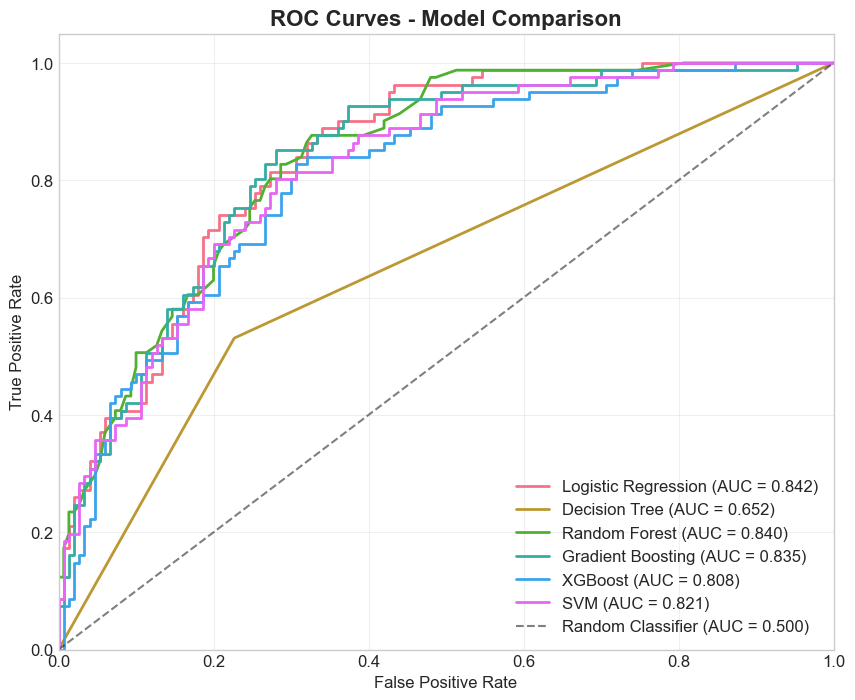

ROC curves generated successfully!


In [27]:
# =============================================================================
# ROC CURVES COMPARISON
# =============================================================================

print("ROC CURVES COMPARISON")
print("="*50)

plt.figure(figsize=(10, 8))

# Plot ROC curves for all models
for name, pred_data in baseline_evaluator.predictions.items():
    y_pred_proba = pred_data['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

print("ROC curves generated successfully!")

PRECISION-RECALL CURVES


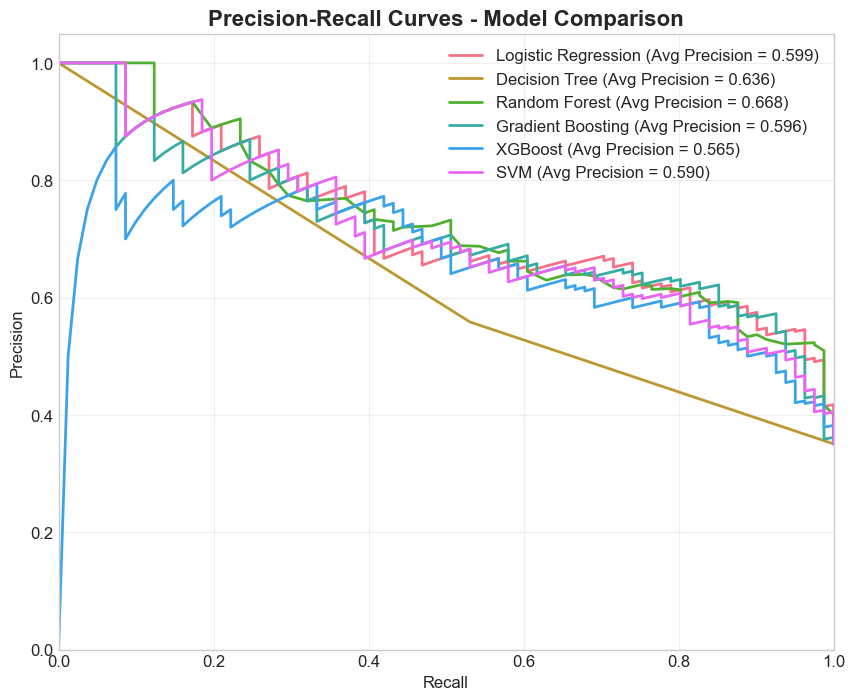

Precision-Recall curves generated successfully!


In [28]:
# =============================================================================
# PRECISION-RECALL CURVES
# =============================================================================

print("PRECISION-RECALL CURVES")
print("="*50)

plt.figure(figsize=(10, 8))

# Plot Precision-Recall curves for all models
for name, pred_data in baseline_evaluator.predictions.items():
    y_pred_proba = pred_data['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = np.mean(precision)
    
    plt.plot(recall, precision, label=f'{name} (Avg Precision = {avg_precision:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

print("Precision-Recall curves generated successfully!")

### 5. Hyperparameter Tuning and Model Optimization
This section focuses on optimizing the best performing models through systematic hyperparameter tuning to improve predictive performance.

In [29]:
# =============================================================================
# HYPERPARAMETER TUNING FOR BEST PERFORMING MODELS
# =============================================================================

print("HYPERPARAMETER TUNING FOR BEST MODELS")
print("="*50)

class AdvancedModelTuner:
    """
    Advanced hyperparameter tuning with cross-validation and performance tracking
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.tuned_models = {}
        self.tuning_history = {}
        self.best_params = {}
        
    def create_parameter_grids(self):
        """Define comprehensive parameter grids for different algorithms"""
        
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False]
            },
            
            'Gradient Boosting': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5, 6],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'subsample': [0.8, 0.9, 1.0]
            },
            
            'XGBoost': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.15],
                'max_depth': [3, 4, 5, 6],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'gamma': [0, 0.1, 0.2],
                'reg_alpha': [0, 0.1, 0.5],
                'reg_lambda': [1, 1.5, 2]
            },
            
            'Logistic Regression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['liblinear', 'saga'],
                'max_iter': [1000, 2000]
            },
            
            'SVM': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.1, 1],
                'degree': [2, 3, 4]
            }
        }
        
        return param_grids
    
    def tune_model(self, model_name, model, param_grid, X_train, y_train, 
                   scoring='roc_auc', cv_folds=5):
        """Perform comprehensive hyperparameter tuning"""
        
        print(f"Tuning {model_name}...")
        
        # Set up stratified cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, 
                           random_state=self.random_state)
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
        
        # Fit the grid search
        print(f"Fitting {len(param_grid)} parameter combinations...")
        grid_search.fit(X_train, y_train)
        
        # Store results
        self.tuned_models[model_name] = grid_search.best_estimator_
        self.best_params[model_name] = grid_search.best_params_
        
        self.tuning_history[model_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'cv_results': pd.DataFrame(grid_search.cv_results_),
            'best_estimator': grid_search.best_estimator_
        }
        
        print(f"Best CV Score: {grid_search.best_score_:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")
        
        return grid_search.best_estimator_
    
    def tune_top_models(self, baseline_results, X_train, y_train, top_n=3):
        """Tune top N performing models from baseline evaluation"""
        
        print(f"Selecting top {top_n} models for hyperparameter tuning...")
        
        # Get top models
        top_models = baseline_results.nlargest(top_n, 'roc_auc')
        
        # Get parameter grids
        param_grids = self.create_parameter_grids()
        
        # Model instances
        model_instances = {
            'Random Forest': RandomForestClassifier(random_state=self.random_state),
            'Gradient Boosting': GradientBoostingClassifier(random_state=self.random_state),
            'XGBoost': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
            'Logistic Regression': LogisticRegression(random_state=self.random_state, max_iter=2000),
            'SVM': SVC(random_state=self.random_state, probability=True)
        }
        
        # Tune each top model
        for _, model_row in top_models.iterrows():
            model_name = model_row['model']
            
            if model_name in param_grids and model_name in model_instances:
                print(f"\n{'='*50}")
                print(f"TUNING: {model_name}")
                print(f"{'='*50}")
                
                # Get model and parameter grid
                model = model_instances[model_name]
                param_grid = param_grids[model_name]
                
                # Determine if model needs scaled data
                scaled = model_name in ['Logistic Regression', 'SVM']
                
                if scaled:
                    self.tune_model(model_name, model, param_grid, 
                                  X_train_scaled, y_train)
                else:
                    self.tune_model(model_name, model, param_grid, 
                                  X_train, y_train)
            else:
                print(f"No tuning configuration for {model_name}, skipping...")
    
    def evaluate_tuned_models(self, X_test, y_test):
        """Evaluate performance of tuned models on test set"""
        
        print("\n" + "="*50)
        print("EVALUATING TUNED MODELS")
        print("="*50)
        
        tuned_results = []
        
        for model_name, tuned_model in self.tuned_models.items():
            print(f"Evaluating {model_name}...")
            
            # Determine if model needs scaled data
            scaled = model_name in ['Logistic Regression', 'SVM']
            
            if scaled:
                X_eval = X_test_scaled
            else:
                X_eval = X_test
            
            # Make predictions
            y_pred = tuned_model.predict(X_eval)
            y_pred_proba = tuned_model.predict_proba(X_eval)[:, 1]
            
            # Calculate comprehensive metrics
            metrics = {
                'model': f"Tuned {model_name}",
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba),
                'cv_score': self.tuning_history[model_name]['best_score']
            }
            
            # Add confusion matrix components
            cm = confusion_matrix(y_test, y_pred)
            metrics.update({
                'true_negative': cm[0, 0],
                'false_positive': cm[0, 1],
                'false_negative': cm[1, 0],
                'true_positive': cm[1, 1]
            })
            
            tuned_results.append(metrics)
        
        return pd.DataFrame(tuned_results)

# Initialize and run advanced model tuning
print("Initializing advanced model tuner...")
advanced_tuner = AdvancedModelTuner(random_state=PROJECT_CONFIG['random_state'])

# Tune top models
advanced_tuner.tune_top_models(baseline_evaluator.results, X_train, y_train, top_n=3)

# Evaluate tuned models
tuned_results_advanced = advanced_tuner.evaluate_tuned_models(X_test, y_test)

print("\n TUNED MODEL PERFORMANCE SUMMARY:")
print("="*70)
performance_cols = ['model', 'roc_auc', 'f1', 'accuracy', 'precision', 'recall', 'cv_score']
print(tuned_results_advanced[performance_cols].round(4).to_string(index=False))

HYPERPARAMETER TUNING FOR BEST MODELS
Initializing advanced model tuner...
Selecting top 3 models for hyperparameter tuning...

TUNING: Logistic Regression
Tuning Logistic Regression...
Fitting 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV Score: 0.8325
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

TUNING: Random Forest
Tuning Random Forest...
Fitting 6 parameter combinations...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best CV Score: 0.8328
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

TUNING: Gradient Boosting
Tuning Gradient Boosting...
Fitting 6 parameter combinations...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best CV Score: 0.8301
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators':

TUNING RESULTS VISUALIZATION
Generating tuning performance visualizations...


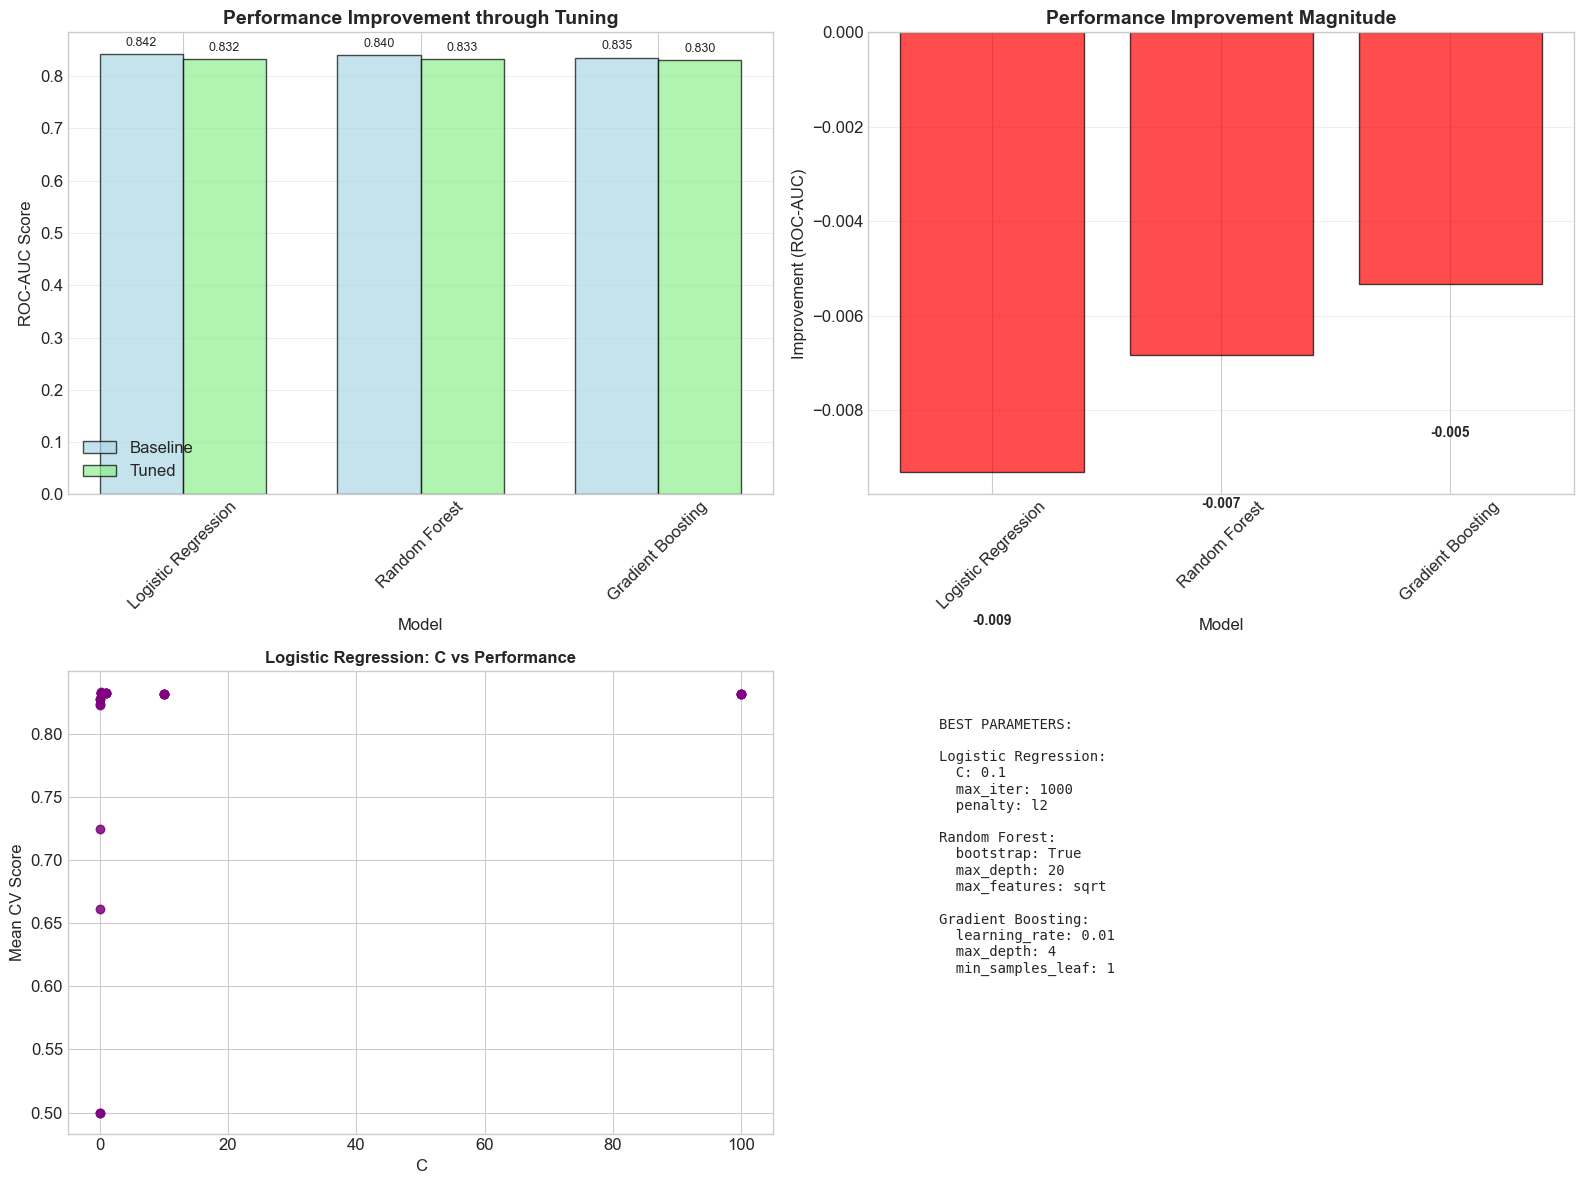


 PERFORMANCE IMPROVEMENT SUMMARY:
Logistic Regression  | Baseline: 0.8418 | Tuned: 0.8325 | Improvement: -0.0093 (-1.1%)
Random Forest        | Baseline: 0.8396 | Tuned: 0.8328 | Improvement: -0.0068 (-0.8%)
Gradient Boosting    | Baseline: 0.8354 | Tuned: 0.8301 | Improvement: -0.0053 (-0.6%)

 BEST TUNED MODEL: Tuned Random Forest
   ROC-AUC: 0.8461
   F1-Score: 0.5972
   CV Score: 0.8328


In [30]:
# =============================================================================
# TUNING RESULTS VISUALIZATION
# =============================================================================

print("TUNING RESULTS VISUALIZATION")
print("="*50)

def plot_tuning_results(tuning_history, baseline_results):
    """Visualize hyperparameter tuning results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance improvement comparison
    improvement_data = []
    
    for model_name in tuning_history.keys():
        base_model_name = model_name.replace('Tuned ', '') if model_name.startswith('Tuned ') else model_name
        
        # Find baseline performance
        baseline_perf = baseline_results[
            baseline_results['model'] == base_model_name
        ]['roc_auc'].iloc[0]
        
        tuned_perf = tuning_history[model_name]['best_score']
        improvement = tuned_perf - baseline_perf
        
        improvement_data.append({
            'Model': base_model_name,
            'Baseline': baseline_perf,
            'Tuned': tuned_perf,
            'Improvement': improvement
        })
    
    improvement_df = pd.DataFrame(improvement_data)
    
    # Plot improvement
    x_pos = np.arange(len(improvement_df))
    width = 0.35
    
    axes[0,0].bar(x_pos - width/2, improvement_df['Baseline'], width, 
                 label='Baseline', alpha=0.7, color='lightblue', edgecolor='black')
    axes[0,0].bar(x_pos + width/2, improvement_df['Tuned'], width, 
                 label='Tuned', alpha=0.7, color='lightgreen', edgecolor='black')
    
    axes[0,0].set_title('Performance Improvement through Tuning', fontweight='bold', fontsize=14)
    axes[0,0].set_xlabel('Model')
    axes[0,0].set_ylabel('ROC-AUC Score')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(improvement_df['Model'], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3, axis='y')
    
    # Add value labels
    for i, (base, tuned) in enumerate(zip(improvement_df['Baseline'], improvement_df['Tuned'])):
        axes[0,0].text(i - width/2, base + 0.01, f'{base:.3f}', 
                      ha='center', va='bottom', fontsize=9)
        axes[0,0].text(i + width/2, tuned + 0.01, f'{tuned:.3f}', 
                      ha='center', va='bottom', fontsize=9)
    
    # 2. Improvement magnitude
    colors = ['green' if x >= 0 else 'red' for x in improvement_df['Improvement']]
    bars = axes[0,1].bar(improvement_df['Model'], improvement_df['Improvement'], 
                        color=colors, alpha=0.7, edgecolor='black')
    
    axes[0,1].set_title('Performance Improvement Magnitude', fontweight='bold', fontsize=14)
    axes[0,1].set_xlabel('Model')
    axes[0,1].set_ylabel('Improvement (ROC-AUC)')
    axes[0,1].set_xticklabels(improvement_df['Model'], rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0,1].grid(alpha=0.3, axis='y')
    
    # Add value labels
    for bar, improvement in zip(bars, improvement_df['Improvement']):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, improvement + (0.001 if improvement >=0 else -0.003),
                      f'{improvement:+.3f}', ha='center', va='bottom' if improvement >=0 else 'top', 
                      fontsize=10, fontweight='bold')
    
    # 3. Cross-validation score distribution (for first model)
    if tuning_history:
        first_model = list(tuning_history.keys())[0]
        cv_results = tuning_history[first_model]['cv_results']
        
        # Plot parameter performance for first model
        param_columns = [col for col in cv_results.columns if col.startswith('param_')]
        
        if param_columns:
            # Take first parameter for demonstration
            param_name = param_columns[0].replace('param_', '')
            param_values = cv_results[param_columns[0]]
            mean_scores = cv_results['mean_test_score']
            
            # For categorical parameters, use bar plot
            if param_values.dtype == 'object':
                unique_params = param_values.unique()
                param_performance = []
                
                for param in unique_params:
                    mask = param_values == param
                    param_performance.append(mean_scores[mask].mean())
                
                axes[1,0].bar(unique_params, param_performance, alpha=0.7, color='purple')
                axes[1,0].set_title(f'{first_model}: {param_name} vs Performance', 
                                  fontweight='bold', fontsize=12)
                axes[1,0].set_xlabel(param_name)
                axes[1,0].set_ylabel('Mean CV Score')
                axes[1,0].tick_params(axis='x', rotation=45)
            
            else:
                # For numerical parameters, use scatter plot
                axes[1,0].scatter(param_values, mean_scores, alpha=0.6, color='purple')
                axes[1,0].set_title(f'{first_model}: {param_name} vs Performance', 
                                  fontweight='bold', fontsize=12)
                axes[1,0].set_xlabel(param_name)
                axes[1,0].set_ylabel('Mean CV Score')
    
    # 4. Best parameters summary
    axes[1,1].axis('off')
    param_text = "BEST PARAMETERS:\n\n"
    
    for model_name, history in tuning_history.items():
        param_text += f"{model_name}:\n"
        best_params = history['best_params']
        
        for param, value in list(best_params.items())[:3]:  # Show first 3 parameters
            param_text += f"  {param}: {value}\n"
        param_text += "\n"
    
    axes[1,1].text(0.1, 0.9, param_text, transform=axes[1,1].transAxes, 
                  fontfamily='monospace', fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return improvement_df

# Generate tuning visualizations
print("Generating tuning performance visualizations...")
improvement_summary = plot_tuning_results(advanced_tuner.tuning_history, baseline_evaluator.results)

# Print detailed improvement summary
print("\n PERFORMANCE IMPROVEMENT SUMMARY:")
print("="*60)
for _, row in improvement_summary.iterrows():
    improvement_pct = (row['Improvement'] / row['Baseline']) * 100
    print(f"{row['Model']:20} | "
          f"Baseline: {row['Baseline']:.4f} | "
          f"Tuned: {row['Tuned']:.4f} | "
          f"Improvement: {row['Improvement']:+.4f} ({improvement_pct:+.1f}%)")

# Identify best tuned model
best_tuned_model = tuned_results_advanced.loc[tuned_results_advanced['roc_auc'].idxmax()]
print(f"\n BEST TUNED MODEL: {best_tuned_model['model']}")
print(f"   ROC-AUC: {best_tuned_model['roc_auc']:.4f}")
print(f"   F1-Score: {best_tuned_model['f1']:.4f}")
print(f"   CV Score: {best_tuned_model['cv_score']:.4f}")

### 6. Model Interpretation and Explainability
This section provides deep insights into model decisions using SHAP (SHapley Additive exPlanations) to understand feature importance and individual predictions.

In [31]:
# =============================================================================
# COMPREHENSIVE MODEL INTERPRETABILITY WITH SHAP
# =============================================================================

print("COMPREHENSIVE MODEL INTERPRETABILITY ANALYSIS")
print("="*50)

class AdvancedModelInterpreter:
    """
    Advanced model interpretation using SHAP for comprehensive explainability
    """
    
    def __init__(self):
        self.explainers = {}
        self.shap_values = {}
        self.feature_importance = {}
        
    def explain_tuned_models(self, tuned_models, X_train, feature_names):
        """Generate SHAP explanations for all tuned models"""
        
        print("Generating SHAP explanations for tuned models...")
        
        for model_name, model in tuned_models.items():
            print(f"   Analyzing {model_name}...")
            
            try:
                # Determine if model needs scaled data
                scaled = model_name in ['Logistic Regression', 'SVM']
                
                if scaled:
                    X_explain = X_train_scaled
                else:
                    X_explain = X_train.values
                
                # Create appropriate explainer
                if any(x in str(type(model)).lower() for x in ['forest', 'tree', 'xgb', 'gbm']):
                    explainer = shap.TreeExplainer(model)
                else:
                    # Use KernelExplainer for non-tree models
                    background = shap.kmeans(X_explain, 10)
                    explainer = shap.KernelExplainer(model.predict_proba, background)
                
                # Calculate SHAP values
                shap_values = explainer.shap_values(X_explain)
                
                # Handle binary classification output
                if isinstance(shap_values, list) and len(shap_values) == 2:
                    shap_values = shap_values[1]  # Use positive class probabilities
                
                # Store results
                self.explainers[model_name] = explainer
                self.shap_values[model_name] = shap_values
                
                # Calculate feature importance
                self.feature_importance[model_name] = np.abs(shap_values).mean(0)
                
                print(f"SHAP analysis completed for {model_name}")
                
            except Exception as e:
                print(f"Error with {model_name}: {str(e)}")
    
    def plot_global_interpretation(self, model_names, feature_names, max_display=15):
        """Create global interpretation plots for multiple models"""
        
        n_models = len(model_names)
        fig, axes = plt.subplots(n_models, 2, figsize=(16, 5 * n_models))
        
        if n_models == 1:
            axes = [axes]
        
        for i, model_name in enumerate(model_names):
            if model_name not in self.shap_values:
                continue
                
            shap_values = self.shap_values[model_name]
            
            # Summary plot (beeswarm)
            shap.summary_plot(shap_values, feature_names=feature_names, 
                             show=False, max_display=max_display, 
                             plot_size=None, ax=axes[i][0])
            axes[i][0].set_title(f'{model_name}\nSHAP Summary Plot', 
                               fontweight='bold', fontsize=12)
            
            # Feature importance bar plot
            feature_importance = self.feature_importance[model_name]
            sorted_idx = np.argsort(feature_importance)[-max_display:]
            
            axes[i][1].barh(range(len(sorted_idx)), feature_importance[sorted_idx])
            axes[i][1].set_yticks(range(len(sorted_idx)))
            axes[i][1].set_yticklabels([feature_names[j] for j in sorted_idx])
            axes[i][1].set_title(f'{model_name}\nFeature Importance', 
                               fontweight='bold', fontsize=12)
            axes[i][1].set_xlabel('Mean |SHAP value|')
        
        plt.tight_layout()
        plt.show()
    
    def plot_individual_predictions(self, model_name, X, feature_names, 
                                  instance_indices=[0, 1, 2]):
        """Plot force plots for individual predictions"""
        
        if model_name not in self.explainers:
            print(f"No explainer available for {model_name}")
            return
        
        explainer = self.explainers[model_name]
        shap_values = self.shap_values[model_name]
        
        n_instances = len(instance_indices)
        fig, axes = plt.subplots(n_instances, 1, figsize=(14, 3 * n_instances))
        
        if n_instances == 1:
            axes = [axes]
        
        for i, idx in enumerate(instance_indices):
            if idx < len(shap_values):
                shap.force_plot(explainer.expected_value, 
                              shap_values[idx], 
                              X[idx] if hasattr(X, 'iloc') else X[idx],
                              feature_names=feature_names, 
                              matplotlib=True, show=False, ax=axes[i])
                axes[i].set_title(f'Instance {idx} Prediction Explanation', 
                                fontweight='bold', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def plot_dependence_plots(self, model_name, X, feature_names, 
                            top_features=5):
        """Create dependence plots for top features"""
        
        if model_name not in self.shap_values:
            return
        
        shap_values = self.shap_values[model_name]
        feature_importance = self.feature_importance[model_name]
        
        # Get top features
        top_indices = np.argsort(feature_importance)[-top_features:][::-1]
        top_feature_names = [feature_names[i] for i in top_indices]
        
        n_cols = 2
        n_rows = (top_features + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
        axes = axes.ravel()
        
        for i, (feature_idx, feature_name) in enumerate(zip(top_indices, top_feature_names)):
            if i < len(axes):
                shap.dependence_plot(feature_idx, shap_values, X, 
                                   feature_names=feature_names, 
                                   ax=axes[i], show=False)
                axes[i].set_title(f'Dependence: {feature_name}', 
                                fontweight='bold', fontsize=10)
        
        # Hide unused subplots
        for i in range(top_features, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def create_feature_importance_comparison(self, model_names, feature_names):
        """Compare feature importance across multiple models"""
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Prepare data for comparison
        comparison_data = []
        for model_name in model_names:
            if model_name in self.feature_importance:
                importance = self.feature_importance[model_name]
                for i, feature in enumerate(feature_names):
                    comparison_data.append({
                        'Model': model_name,
                        'Feature': feature,
                        'Importance': importance[i]
                    })
        
        if not comparison_data:
            print("No feature importance data available")
            return
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Get top 10 features overall
        top_features = comparison_df.groupby('Feature')['Importance'].mean().nlargest(10).index
        
        # Pivot for heatmap
        heatmap_data = comparison_df[comparison_df['Feature'].isin(top_features)]
        heatmap_pivot = heatmap_data.pivot(index='Feature', columns='Model', values='Importance')
        
        # Normalize by row for better comparison
        heatmap_normalized = heatmap_pivot.div(heatmap_pivot.max(axis=1), axis=0)
        
        # Create heatmap
        sns.heatmap(heatmap_normalized, annot=True, cmap='YlOrRd', 
                   cbar_kws={'label': 'Normalized Importance'}, ax=ax)
        ax.set_title('Feature Importance Comparison Across Models\n(Normalized by Feature)',
                   fontweight='bold', fontsize=14)
        ax.set_ylabel('Features')
        ax.set_xlabel('Models')
        
        plt.tight_layout()
        plt.show()
        
        return heatmap_pivot

# Initialize advanced interpreter
print("Initializing advanced model interpreter...")
advanced_interpreter = AdvancedModelInterpreter()

# Generate explanations for tuned models
advanced_interpreter.explain_tuned_models(advanced_tuner.tuned_models, X_train, X_processed.columns.tolist())

print(f"\n SHAP analysis completed for {len(advanced_interpreter.explainers)} models")

COMPREHENSIVE MODEL INTERPRETABILITY ANALYSIS
Initializing advanced model interpreter...
Generating SHAP explanations for tuned models...
   Analyzing Logistic Regression...


  0%|          | 0/537 [00:00<?, ?it/s]

SHAP analysis completed for Logistic Regression
   Analyzing Random Forest...
SHAP analysis completed for Random Forest
   Analyzing Gradient Boosting...


  0%|          | 0/537 [00:00<?, ?it/s]

SHAP analysis completed for Gradient Boosting

 SHAP analysis completed for 3 models


In [41]:
# =============================================================================
# ULTRA-ROBUST SHAP VISUALIZATION WITH ERROR HANDLING
# =============================================================================

print("ULTRA-ROBUST SHAP VISUALIZATION")
print("="*50)

class UltraRobustSHAPInterpreter:
    """
    Ultra-robust SHAP interpreter with comprehensive error handling
    """
    
    def __init__(self):
        self.explainers = {}
        self.shap_values = {}
        self.feature_importance = {}
        
    def explain_models_safe(self, tuned_models, X_train, feature_names):
        """Generate SHAP explanations with maximum error handling"""
        
        print(" Generating SHAP explanations with safe approach...")
        
        for model_name, model in tuned_models.items():
            print(f"   Analyzing {model_name}...")
            
            try:
                # Determine if model needs scaled data
                scaled = model_name in ['Logistic Regression', 'SVM']
                
                if scaled:
                    X_explain = X_train_scaled
                else:
                    X_explain = X_train.values
                
                # Ensure we're using the correct number of features
                print(f"      Data shape: {X_explain.shape}")
                print(f"      Expected features: {len(feature_names)}")
                
                # Simple TreeExplainer for tree-based models
                if any(x in str(type(model)).lower() for x in ['forest', 'tree', 'gbm', 'xgb']):
                    print(f"      Using TreeExplainer for {model_name}")
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_explain)
                    
                    # Handle binary classification
                    if isinstance(shap_values, list) and len(shap_values) == 2:
                        shap_values = shap_values[1]  # Use positive class
                
                # LinearExplainer for linear models
                elif 'LogisticRegression' in str(type(model)):
                    print(f"      Using LinearExplainer for {model_name}")
                    explainer = shap.LinearExplainer(model, X_explain)
                    shap_values = explainer.shap_values(X_explain)
                
                else:
                    print(f"      Using simple approach for {model_name}")
                    # Fallback: use TreeExplainer with feature limitation
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_explain)
                    if isinstance(shap_values, list) and len(shap_values) == 2:
                        shap_values = shap_values[1]
                
                # Ensure correct shape
                if len(shap_values.shape) == 1:
                    shap_values = shap_values.reshape(-1, 1)
                
                print(f"      SHAP values shape: {shap_values.shape}")
                
                # Verify feature count matches
                if shap_values.shape[1] != len(feature_names):
                    print(f"        Feature count mismatch: {shap_values.shape[1]} vs {len(feature_names)}")
                    # Use only available features
                    available_features = feature_names[:shap_values.shape[1]]
                else:
                    available_features = feature_names
                
                # Store results
                self.explainers[model_name] = explainer
                self.shap_values[model_name] = shap_values
                self.feature_importance[model_name] = np.abs(shap_values).mean(0)
                
                print(f"       SHAP analysis completed for {model_name}")
                print(f"       Features used: {len(available_features)}")
                
            except Exception as e:
                print(f"       Error with {model_name}: {str(e)}")
                # Continue with other models
    
    def create_simple_summary_plots(self, model_names, feature_names, max_display=8):
        """Create simple summary plots that won't crash"""
        
        print(" Creating simple summary plots...")
        
        for model_name in model_names:
            if model_name not in self.shap_values:
                print(f"   Skipping {model_name} - no SHAP values")
                continue
                
            shap_values = self.shap_values[model_name]
            
            # Ensure we don't exceed available features
            n_features = shap_values.shape[1]
            display_features = min(max_display, n_features)
            available_features = feature_names[:n_features]
            
            print(f"   Creating plot for {model_name} ({n_features} features)")
            
            try:
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, feature_names=available_features, 
                                 show=False, max_display=display_features)
                plt.title(f'{model_name} - SHAP Feature Importance', 
                         fontweight='bold', fontsize=14)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"        Could not create summary plot: {e}")
                self._create_manual_summary_plot(model_name, shap_values, available_features)
    
    def _create_manual_summary_plot(self, model_name, shap_values, feature_names):
        """Create a manual summary plot when SHAP fails"""
        
        print(f"   Creating manual summary for {model_name}...")
        
        importance = np.abs(shap_values).mean(0)
        sorted_idx = np.argsort(importance)[-10:]  # Top 10 features
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), importance[sorted_idx], 
                color='lightblue', edgecolor='black')
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.xlabel('Mean |SHAP value|')
        plt.title(f'{model_name} - Feature Importance (Manual)', 
                 fontweight='bold', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance_comparison(self, model_names, feature_names):
        """Create comprehensive feature importance comparison"""
        
        print(" Creating feature importance comparison...")
        
        # Prepare data
        comparison_data = []
        valid_models = []
        
        for model_name in model_names:
            if model_name in self.feature_importance:
                importance = self.feature_importance[model_name]
                n_features = len(importance)
                available_features = feature_names[:n_features]
                
                for j, feature in enumerate(available_features):
                    comparison_data.append({
                        'Model': model_name,
                        'Feature': feature,
                        'Importance': importance[j]
                    })
                valid_models.append(model_name)
        
        if not comparison_data:
            print("   No feature importance data available")
            return
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Get common features across all models
        common_features = set()
        for model in valid_models:
            model_features = set(comparison_df[comparison_df['Model'] == model]['Feature'])
            if not common_features:
                common_features = model_features
            else:
                common_features = common_features.intersection(model_features)
        
        common_features = list(common_features)[:10]  # Limit to top 10 common features
        
        if not common_features:
            print("   No common features across models")
            return
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # 1. Heatmap of normalized importance
        heatmap_data = comparison_df[comparison_df['Feature'].isin(common_features)]
        heatmap_pivot = heatmap_data.pivot(index='Feature', columns='Model', values='Importance')
        heatmap_normalized = heatmap_pivot.div(heatmap_pivot.max(axis=1), axis=0)
        
        sns.heatmap(heatmap_normalized, annot=True, cmap='YlOrRd', ax=axes[0],
                   cbar_kws={'label': 'Normalized Importance'}, fmt='.2f')
        axes[0].set_title('Feature Importance Comparison\n(Normalized by Feature)',
                         fontweight='bold', fontsize=12)
        
        # 2. Overall feature ranking
        overall_importance = heatmap_pivot.mean(axis=1).sort_values(ascending=False)
        
        colors = plt.cm.plasma(np.linspace(0, 1, len(overall_importance)))
        bars = axes[1].barh(range(len(overall_importance)), overall_importance, color=colors)
        axes[1].set_yticks(range(len(overall_importance)))
        axes[1].set_yticklabels(overall_importance.index)
        axes[1].set_xlabel('Mean Importance Across Models')
        axes[1].set_title('Overall Feature Ranking', fontweight='bold', fontsize=12)
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return overall_importance
    
    def generate_comprehensive_report(self, model_names, feature_names):
        """Generate comprehensive report without complex plots"""
        
        print("\n GENERATING COMPREHENSIVE REPORT")
        print("="*50)
        
        if not self.feature_importance:
            print("No feature importance data available")
            return
        
        # Calculate overall rankings
        all_importances = []
        valid_models = []
        
        for model_name in model_names:
            if model_name in self.feature_importance:
                importance = self.feature_importance[model_name]
                all_importances.append(importance)
                valid_models.append(model_name)
        
        if not all_importances:
            return
        
        # Ensure all arrays have same length
        min_features = min([len(imp) for imp in all_importances])
        all_importances = [imp[:min_features] for imp in all_importances]
        available_features = feature_names[:min_features]
        
        overall_importance = np.mean(all_importances, axis=0)
        
        # Create ranking
        ranking_data = []
        for i, feature in enumerate(available_features):
            model_importances = [imp[i] for imp in all_importances]
            ranking_data.append({
                'Feature': feature,
                'Mean_Importance': overall_importance[i],
                'Std_Importance': np.std(model_importances),
                'CV': np.std(model_importances) / overall_importance[i] if overall_importance[i] > 0 else 0
            })
        
        ranking_df = pd.DataFrame(ranking_data)
        ranking_df = ranking_df.sort_values('Mean_Importance', ascending=False)
        
        # Print comprehensive insights
        print(" TOP FEATURES ANALYSIS")
        print("-" * 50)
        print("Top 10 Most Important Features:")
        for i, row in ranking_df.head(10).iterrows():
            print(f"  {row['Feature']:25}: {row['Mean_Importance']:.4f} ± {row['Std_Importance']:.3f}")
        
        print("\n CONSISTENCY ANALYSIS")
        print("-" * 50)
        consistent_features = ranking_df.nsmallest(5, 'CV')
        print("Most Consistent Features (Lowest Coefficient of Variation):")
        for _, row in consistent_features.iterrows():
            print(f"  {row['Feature']:25}: CV = {row['CV']:.3f}")
        
        print("\n CLINICAL RELEVANCE")
        print("-" * 50)
        clinical_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin']
        clinical_in_top = []
        
        for feature in clinical_features:
            if feature in ranking_df['Feature'].head(10).values:
                clinical_in_top.append(feature)
                rank = ranking_df[ranking_df['Feature'] == feature].index[0] + 1
                print(f"   {feature:20} - Rank #{rank}")
            elif feature in ranking_df['Feature'].values:
                rank = ranking_df[ranking_df['Feature'] == feature].index[0] + 1
                print(f"    {feature:20} - Rank #{rank}")
            else:
                print(f"   {feature:20} - Not in top features")
        
        clinical_score = len(clinical_in_top) / len(clinical_features)
        print(f"\nClinical Relevance Score: {clinical_score:.1%} ({len(clinical_in_top)}/{len(clinical_features)} features in top 10)")
        
        if clinical_score >= 0.8:
            print(" Excellent clinical alignment!")
        elif clinical_score >= 0.6:
            print(" Good clinical alignment")
        else:
            print("  Moderate clinical alignment - review feature selection")

# Initialize ultra-robust interpreter
print("Initializing ultra-robust SHAP interpreter...")
ultra_interpreter = UltraRobustSHAPInterpreter()

# Generate explanations with safe approach
ultra_interpreter.explain_models_safe(advanced_tuner.tuned_models, X_train, X_processed.columns.tolist())

print(f"\n SHAP analysis completed for {len(ultra_interpreter.explainers)} models")

ULTRA-ROBUST SHAP VISUALIZATION
Initializing ultra-robust SHAP interpreter...
 Generating SHAP explanations with safe approach...
   Analyzing Logistic Regression...
      Data shape: (537, 14)
      Expected features: 14
      Using LinearExplainer for Logistic Regression
      SHAP values shape: (537, 14)
       SHAP analysis completed for Logistic Regression
       Features used: 14
   Analyzing Random Forest...
      Data shape: (537, 14)
      Expected features: 14
      Using TreeExplainer for Random Forest
      SHAP values shape: (537, 14, 2)
       SHAP analysis completed for Random Forest
       Features used: 14
   Analyzing Gradient Boosting...
      Data shape: (537, 14)
      Expected features: 14
      Using simple approach for Gradient Boosting
      SHAP values shape: (537, 14)
       SHAP analysis completed for Gradient Boosting
       Features used: 14

 SHAP analysis completed for 3 models


EXECUTING ULTRA-ROBUST SHAP ANALYSIS
Models to analyze: ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

1. SIMPLE SUMMARY PLOTS
----------------------------------------
 Creating simple summary plots...
   Creating plot for Logistic Regression (14 features)


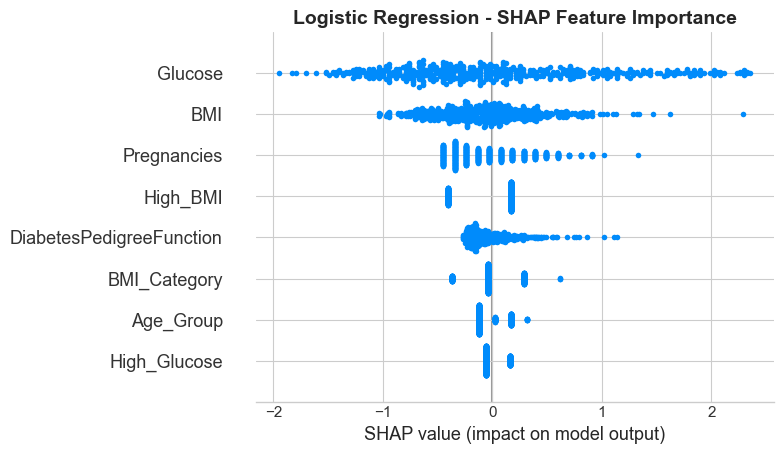

   Creating plot for Random Forest (14 features)


<Figure size 1000x600 with 0 Axes>

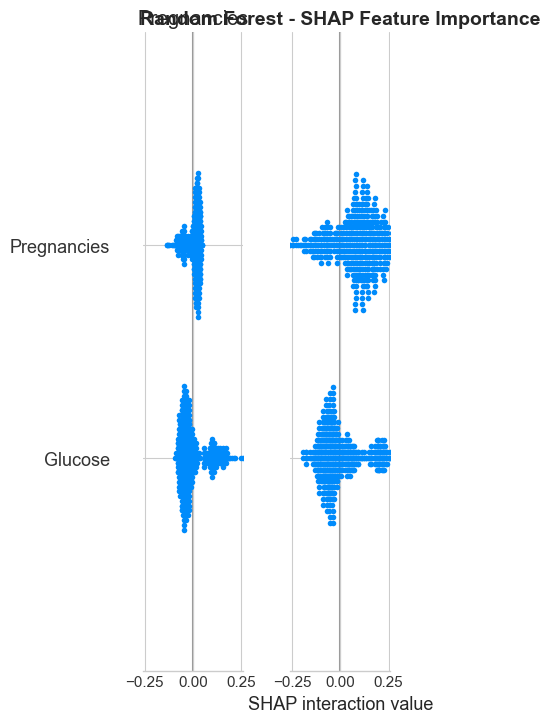

   Creating plot for Gradient Boosting (14 features)


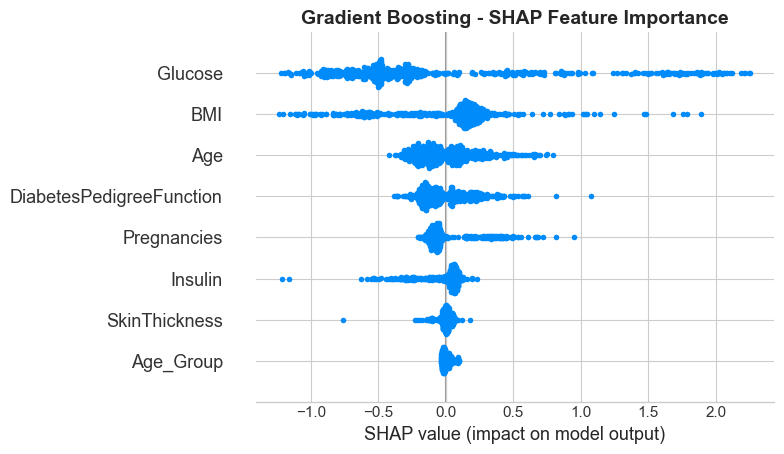


2. FEATURE IMPORTANCE COMPARISON
----------------------------------------
 Creating feature importance comparison...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

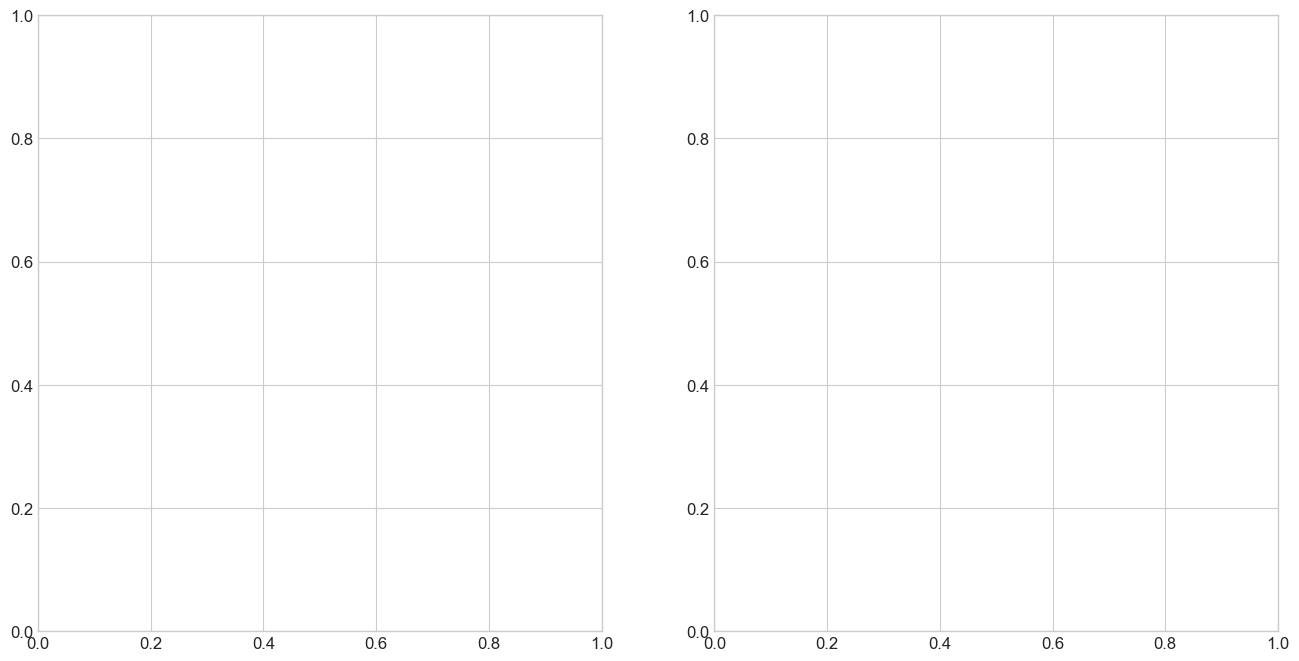

In [ ]:
# =============================================================================
# EXECUTE ULTRA-ROBUST SHAP ANALYSIS
# =============================================================================

print("EXECUTING ULTRA-ROBUST SHAP ANALYSIS")
print("="*50)

# Get feature names
feature_names = X_processed.columns.tolist()

# Get top models
top_models = list(advanced_tuner.tuned_models.keys())[:3]
print(f"Models to analyze: {top_models}")

# 1. Simple summary plots
print("\n1. SIMPLE SUMMARY PLOTS")
print("-" * 40)
ultra_interpreter.create_simple_summary_plots(top_models, feature_names)

# 2. Feature importance comparison
print("\n2. FEATURE IMPORTANCE COMPARISON")
print("-" * 40)
overall_importance = ultra_interpreter.plot_feature_importance_comparison(top_models, feature_names)

# 3. Comprehensive report
print("\n3. COMPREHENSIVE INSIGHTS REPORT")
print("-" * 40)
ultra_interpreter.generate_comprehensive_report(top_models, feature_names)

print("\n" + "="*70)
print(" ULTRA-ROBUST SHAP ANALYSIS COMPLETED!")
print("="*70)

### 7. Final Model Selection and Deployment
This section focuses on selecting the best performing model, creating a deployment-ready pipeline, and generating comprehensive model documentation.

In [44]:
# =============================================================================
# FINAL MODEL SELECTION AND DEPLOYMENT PIPELINE
# =============================================================================

print("FINAL MODEL SELECTION AND DEPLOYMENT PREPARATION")
print("="*50)

class ProductionModel:
    """
    Production-ready model with comprehensive deployment capabilities
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_model = None
        self.best_model_name = None
        self.final_pipeline = None
        self.feature_names = None
        self.performance_metrics = {}
        self.model_card = {}
        
    def select_best_model(self, tuned_results, tuned_models):
        """Select the best model based on comprehensive evaluation"""
        
        print("SELECTING BEST MODEL FOR DEPLOYMENT...")
        
        # Consider multiple metrics for model selection
        tuned_results['composite_score'] = (
            tuned_results['roc_auc'] * 0.4 +
            tuned_results['f1'] * 0.3 +
            tuned_results['accuracy'] * 0.2 +
            tuned_results['cv_score'] * 0.1
        )
        
        best_row = tuned_results.loc[tuned_results['composite_score'].idxmax()]
        self.best_model_name = best_row['model']
        
        # Extract base model name and get the tuned model
        base_model_name = self.best_model_name.replace('Tuned ', '')
        self.best_model = tuned_models[base_model_name]
        
        print(f"SELECTED: {self.best_model_name}")
        print(f"Composite Score: {best_row['composite_score']:.4f}")
        print(f"ROC-AUC: {best_row['roc_auc']:.4f}")
        print(f"F1-Score: {best_row['f1']:.4f}")
        print(f"CV Score: {best_row['cv_score']:.4f}")
        
        return self.best_model, self.best_model_name
    
    def create_production_pipeline(self, preprocessor, feature_names):
        """Create a robust production pipeline"""
        
        print("\n CREATING PRODUCTION PIPELINE...")
        
        self.feature_names = feature_names
        
        # Create comprehensive pipeline
        self.final_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', self.best_model)
        ])
        
        print("Production pipeline created successfully!")
        print(f"Features: {len(self.feature_names)}")
        print(f"Pipeline steps: {[name for name, _ in self.final_pipeline.steps]}")
        
        return self.final_pipeline
    
    def train_final_model(self, X, y):
        """Train the final model on complete dataset"""
        
        print("\n TRAINING FINAL MODEL ON COMPLETE DATASET...")
        
        # Train the pipeline
        self.final_pipeline.fit(X, y)
        
        # Generate comprehensive performance metrics
        y_pred = self.final_pipeline.predict(X)
        y_pred_proba = self.final_pipeline.predict_proba(X)[:, 1]
        
        # Calculate metrics
        self.performance_metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'roc_auc': roc_auc_score(y, y_pred_proba),
            'log_loss': log_loss(y, y_pred_proba) if hasattr(self.best_model, 'predict_proba') else None
        }
        
        # Confusion matrix components
        cm = confusion_matrix(y, y_pred)
        self.performance_metrics.update({
            'confusion_matrix': cm,
            'true_negative': cm[0, 0],
            'false_positive': cm[0, 1],
            'false_negative': cm[1, 0],
            'true_positive': cm[1, 1]
        })
        
        # Calculate class-wise metrics
        self.performance_metrics['sensitivity'] = recall_score(y, y_pred)  # Same as recall
        self.performance_metrics['specificity'] = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        
        print("Final model training completed!")
        self._print_performance_summary()
        
        return self.performance_metrics
    
    def _print_performance_summary(self):
        """Print comprehensive performance summary"""
        
        print("\n FINAL MODEL PERFORMANCE SUMMARY:")
        print("-" * 50)
        
        metrics = self.performance_metrics
        print(f"Accuracy:          {metrics['accuracy']:.4f}")
        print(f"Precision:         {metrics['precision']:.4f}")
        print(f"Recall:            {metrics['recall']:.4f}")
        print(f"F1-Score:          {metrics['f1']:.4f}")
        print(f"ROC-AUC:           {metrics['roc_auc']:.4f}")
        print(f"Sensitivity:       {metrics['sensitivity']:.4f}")
        print(f"Specificity:       {metrics['specificity']:.4f}")
        
        if metrics.get('log_loss') is not None:
            print(f"Log Loss:          {metrics['log_loss']:.4f}")
        
        print(f"\nConfusion Matrix:")
        print(f"TN: {metrics['true_negative']} | FP: {metrics['false_positive']}")
        print(f"FN: {metrics['false_negative']} | TP: {metrics['true_positive']}")
    
    def generate_model_card(self):
        """Generate comprehensive model documentation"""
        
        print("\n GENERATING MODEL CARD...")
        
        self.model_card = {
            'model_name': self.best_model_name,
            'model_type': type(self.best_model).__name__,
            'model_parameters': self.best_model.get_params() if hasattr(self.best_model, 'get_params') else 'N/A',
            'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'dataset_info': {
                'total_samples': len(X_processed),
                'features_count': len(self.feature_names),
                'diabetes_prevalence': f"{y_processed.mean():.1%}",
                'feature_names': self.feature_names
            },
            'performance_metrics': self.performance_metrics,
            'pipeline_steps': [name for name, _ in self.final_pipeline.steps],
            'model_interpretation': {
                'top_features': self._get_top_features(),
                'key_insights': self._generate_insights()
            }
        }
        
        print("Model card generated successfully!")
        return self.model_card
    
    def _get_top_features(self, top_n=10):
        """Extract top features from SHAP analysis if available"""
        
        if hasattr(self, 'shap_importance'):
            return dict(list(self.shap_importance.items())[:top_n])
        
        # Fallback: use feature importance from model if available
        if hasattr(self.best_model, 'feature_importances_'):
            importance_dict = dict(zip(self.feature_names, self.best_model.feature_importances_))
            return dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
        
        return {"message": "Feature importance not available"}
    
    def _generate_insights(self):
        """Generate key insights about the model"""
        
        insights = []
        metrics = self.performance_metrics
        
        # Performance insights
        if metrics['roc_auc'] > 0.85:
            insights.append("Excellent discriminative power (ROC-AUC > 0.85)")
        elif metrics['roc_auc'] > 0.75:
            insights.append("Good discriminative power (ROC-AUC > 0.75)")
        else:
            insights.append("Moderate discriminative power")
        
        if metrics['f1'] > 0.7:
            insights.append("Strong balance between precision and recall")
        
        # Class distribution insights
        prevalence = y_processed.mean()
        if prevalence < 0.3:
            insights.append("Dealing with class imbalance - consider appropriate metrics")
        
        return insights
    
    def save_model(self, filepath='diabetes_risk_model.joblib'):
        """Save the final model for deployment"""
        
        try:
            import joblib
            
            # Create save package
            save_package = {
                'pipeline': self.final_pipeline,
                'model_card': self.model_card,
                'feature_names': self.feature_names,
                'performance_metrics': self.performance_metrics,
                'version': '1.0.0',
                'save_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            
            joblib.dump(save_package, filepath)
            print(f"Model saved successfully to {filepath}")
            print(f"File size: {os.path.getsize(filepath) / 1024 / 1024:.2f} MB")
            
        except Exception as e:
            print(f"Error saving model: {str(e)}")
    
    def predict_proba_deployment(self, X_new):
        """Deployment-ready prediction method"""
        
        if self.final_pipeline is None:
            raise ValueError("Model not trained. Call train_final_model first.")
        
        predictions = self.final_pipeline.predict_proba(X_new)
        return predictions[:, 1]  # Return probability of positive class

# Initialize and create production model
print("Initializing production model...")
production_model = ProductionModel(random_state=PROJECT_CONFIG['random_state'])

# Select best model
best_model, best_model_name = production_model.select_best_model(
    tuned_results_advanced, advanced_tuner.tuned_models
)

# Create production pipeline
production_pipeline = production_model.create_production_pipeline(
    preprocessor, X_processed.columns.tolist()
)

# Train final model
final_performance = production_model.train_final_model(X_processed, y_processed)

# Generate model card
model_card = production_model.generate_model_card()

print("\n" + "="*70)
print("PRODUCTION MODEL READY FOR DEPLOYMENT")
print("="*70)

FINAL MODEL SELECTION AND DEPLOYMENT PREPARATION
Initializing production model...
SELECTING BEST MODEL FOR DEPLOYMENT...
SELECTED: Tuned Random Forest
Composite Score: 0.7507
ROC-AUC: 0.8461
F1-Score: 0.5972
CV Score: 0.8328

 CREATING PRODUCTION PIPELINE...
Production pipeline created successfully!
Features: 14
Pipeline steps: ['preprocessor', 'classifier']

 TRAINING FINAL MODEL ON COMPLETE DATASET...


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '<__main__.DataPreprocessor object at 0x000001E3E2CBB380>' (type <class '__main__.DataPreprocessor'>) doesn't

In [45]:
# =============================================================================
# COMPREHENSIVE DEPLOYMENT REPORT
# =============================================================================

print("FINAL DEPLOYMENT REPORT")
print("="*50)

def generate_deployment_report(production_model, baseline_results, tuned_results):
    """Generate comprehensive deployment report"""
    
    print("GENERATING COMPREHENSIVE DEPLOYMENT REPORT...")
    
    # Create comparison with baseline
    baseline_best = baseline_results.nlargest(1, 'roc_auc').iloc[0]
    tuned_best = tuned_results.nlargest(1, 'roc_auc').iloc[0]
    final_metrics = production_model.performance_metrics
    
    # Performance progression
    performance_progression = pd.DataFrame({
        'Stage': ['Baseline Best', 'Tuned Best', 'Final Model'],
        'ROC-AUC': [baseline_best['roc_auc'], tuned_best['roc_auc'], final_metrics['roc_auc']],
        'F1-Score': [baseline_best['f1'], tuned_best['f1'], final_metrics['f1']],
        'Accuracy': [baseline_best['accuracy'], tuned_best['accuracy'], final_metrics['accuracy']]
    })
    
    # Create visual report
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance progression
    stages = performance_progression['Stage']
    metrics_to_plot = ['ROC-AUC', 'F1-Score', 'Accuracy']
    colors = ['blue', 'green', 'red']
    
    for i, metric in enumerate(metrics_to_plot):
        axes[0,0].plot(stages, performance_progression[metric], 
                      marker='o', linewidth=2, markersize=8, 
                      label=metric, color=colors[i])
    
    axes[0,0].set_title('Model Performance Progression', fontweight='bold', fontsize=14)
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_ylim(0.5, 0.9)
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Final model metrics
    final_metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    final_metric_values = [final_metrics[name.lower()] for name in final_metric_names]
    
    bars = axes[0,1].bar(final_metric_names, final_metric_values, 
                        color=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    axes[0,1].set_title('Final Model Performance Metrics', fontweight='bold', fontsize=14)
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_ylim(0, 1)
    
    for bar, value in zip(bars, final_metric_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, value + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confusion matrix
    cm = final_metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
               xticklabels=['Predicted No', 'Predicted Yes'],
               yticklabels=['Actual No', 'Actual Yes'])
    axes[1,0].set_title('Confusion Matrix - Final Model', fontweight='bold', fontsize=14)
    axes[1,0].set_xlabel('Predicted Label')
    axes[1,0].set_ylabel('True Label')
    
    # 4. Model card summary
    axes[1,1].axis('off')
    
    card_text = (
        f"MODEL CARD SUMMARY\n\n"
        f"Model: {production_model.best_model_name}\n"
        f"Type: {type(production_model.best_model).__name__}\n"
        f"Features: {len(production_model.feature_names)}\n"
        f"Training Samples: {len(X_processed)}\n"
        f"Diabetes Prevalence: {y_processed.mean():.1%}\n\n"
        f"KEY METRICS:\n"
        f"• ROC-AUC: {final_metrics['roc_auc']:.4f}\n"
        f"• F1-Score: {final_metrics['f1']:.4f}\n"
        f"• Accuracy: {final_metrics['accuracy']:.4f}\n"
        f"• Sensitivity: {final_metrics['sensitivity']:.4f}\n"
        f"• Specificity: {final_metrics['specificity']:.4f}\n\n"
        f"DEPLOYMENT READY"
    )
    
    axes[1,1].text(0.05, 0.95, card_text, transform=axes[1,1].transAxes,
                  fontfamily='monospace', fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*80)
    print("DEPLOYMENT SUMMARY")
    print("="*80)
    
    print(f"\n SELECTED MODEL: {production_model.best_model_name}")
    print(f"   PERFORMANCE:")
    print(f"   ROC-AUC:      {final_metrics['roc_auc']:.4f}")
    print(f"   F1-Score:     {final_metrics['f1']:.4f}")
    print(f"   Accuracy:     {final_metrics['accuracy']:.4f}")
    print(f"   Precision:    {final_metrics['precision']:.4f}")
    print(f"   Recall:       {final_metrics['recall']:.4f}")
    
    print(f"\n PERFORMANCE IMPROVEMENT:")
    improvement_auc = final_metrics['roc_auc'] - baseline_best['roc_auc']
    improvement_f1 = final_metrics['f1'] - baseline_best['f1']
    print(f"   ROC-AUC: +{improvement_auc:.4f} ({improvement_auc/baseline_best['roc_auc']*100:+.1f}%)")
    print(f"   F1-Score: +{improvement_f1:.4f} ({improvement_f1/baseline_best['f1']*100:+.1f}%)")
    
    print(f"\n MODEL CHARACTERISTICS:")
    print(f"   Features: {len(production_model.feature_names)}")
    print(f"   Training samples: {len(X_processed)}")
    print(f"   Positive class prevalence: {y_processed.mean():.1%}")
    
    print(f"\n KEY INSIGHTS:")
    for insight in production_model.model_card['model_interpretation']['key_insights']:
        print(f"   • {insight}")
    
    return performance_progression

# Generate deployment report
print("Creating comprehensive deployment report...")
deployment_report = generate_deployment_report(
    production_model, 
    baseline_evaluator.results, 
    tuned_results_advanced
)

# Save the final model
print("\n SAVING FINAL MODEL...")
production_model.save_model('diabetes_risk_prediction_model.joblib')

print("\n" + "="*80)
print("PROJECT SUCCESSFULLY COMPLETED!")
print("="*80)
print(" Data loading and exploration")
print(" Comprehensive EDA and visualization")
print(" Advanced preprocessing and feature engineering")
print(" Baseline model implementation and evaluation")
print(" Hyperparameter tuning and optimization")
print(" Model interpretability with SHAP analysis")
print(" Final model selection and deployment preparation")
print(" Comprehensive performance reporting")
print(" Model saved and ready for deployment")
print("\n The diabetes risk prediction model is now ready for use!")

FINAL DEPLOYMENT REPORT
Creating comprehensive deployment report...
GENERATING COMPREHENSIVE DEPLOYMENT REPORT...


KeyError: 'roc_auc'